In [50]:
import warnings

warnings.filterwarnings('ignore')

In [51]:
import pandas as pd
import numpy as np
import yfinance as yf
% matplotlib inline
import matplotlib.pyplot as plt
from scipy.signal import *

# Plot Multiple Regime Methodologies in a Colorful Chart

In [52]:
def graph_regime_combo(ticker, df, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch,
                       ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo, st_hi):
    '''
    https://www.color-hex.com/color-names.html
    ticker,df,_c: _c is closing price
    rg: regime -1/0/1 using floor/ceiling method
    lo,hi: small, noisy highs/lows
    slo,shi: swing lows/highs
    clg,flr: ceiling/floor

    rg_ch: regime change base
    ma_st,ma_mt,ma_lt: moving averages ST/MT/LT
    lt_lo,lt_hi: range breakout High/Low LT
    st_lo,st_hi: range breakout High/Low ST
    '''
    fig = plt.figure(figsize=(20, 8))
    ax1 = plt.subplot2grid((1, 1), (0, 0))
    date = df.index
    close = df[_c]
    ax1.plot_date(df.index, close, '-', color='k', label=ticker.upper())
    try:
        if pd.notnull(rg):
            base = df[rg_ch]
            regime = df[rg]

            if df[lo].count() > 0:
                ax1.plot(df.index, df[lo], '.', color='r', label='swing low', alpha=0.6)
            if df[hi].count() > 0:
                ax1.plot(df.index, df[hi], '.', color='g', label='swing high', alpha=0.6)
            if df[slo].count() > 0:
                ax1.plot(df.index, df[slo], 'o', color='r', label='swing low', alpha=0.8)
            if df[shi].count() > 0:
                ax1.plot(df.index, df[shi], 'o', color='g', label='swing high', alpha=0.8)
            if df[flr].count() > 0:
                plt.scatter(df.index, df[flr], c='k', marker='^', label='floor')
            if df[clg].count() > 0:
                plt.scatter(df.index, df[clg], c='k', marker='v', label='ceiling')

            ax1.plot([], [], linewidth=5, label='bear', color='m', alpha=0.1)
            ax1.plot([], [], linewidth=5, label='bull', color='b', alpha=0.1)
            ax1.fill_between(date, close, base, where=((regime == 1) & (close > base)), facecolor='b', alpha=0.1)
            ax1.fill_between(date, close, base, where=((regime == 1) & (close < base)), facecolor='b', alpha=0.4)
            ax1.fill_between(date, close, base, where=((regime == -1) & (close < base)), facecolor='m', alpha=0.1)
            ax1.fill_between(date, close, base, where=((regime == -1) & (close > base)), facecolor='m', alpha=0.4)

        if np.sum(ma_st) > 0:
            ax1.plot(df.index, ma_st, '-', color='lime', label='ST MA')
            ax1.plot(df.index, ma_mt, '-', color='green', label='MT MA')
            ax1.plot(df.index, ma_lt, '-', color='red', label='LT MA')

            if pd.notnull(rg):  # floor/ceiling regime present
                # Profitable conditions
                ax1.fill_between(date, close, ma_mt, where=((regime == 1) & (ma_mt >= ma_lt) & (ma_st >= ma_mt)),
                                 facecolor='green', alpha=0.5)
                ax1.fill_between(date, close, ma_mt, where=((regime == -1) & (ma_mt <= ma_lt) & (ma_st <= ma_mt)),
                                 facecolor='red', alpha=0.5)
                # Unprofitable conditions
                ax1.fill_between(date, close, ma_mt,
                                 where=((regime == 1) & (ma_mt >= ma_lt) & (ma_st >= ma_mt) & (close < ma_mt)),
                                 facecolor='darkgreen', alpha=1)
                ax1.fill_between(date, close, ma_mt,
                                 where=((regime == -1) & (ma_mt <= ma_lt) & (ma_st <= ma_mt) & (close >= ma_mt)),
                                 facecolor='darkred', alpha=1)

            elif pd.isnull(rg):  # floor/ceiling regime absent
                # Profitable conditions
                ax1.fill_between(date, close, ma_mt, where=((ma_mt >= ma_lt) & (ma_st >= ma_mt)),
                                 facecolor='green', alpha=0.4)
                ax1.fill_between(date, close, ma_mt, where=((ma_mt <= ma_lt) & (ma_st <= ma_mt)),
                                 facecolor='red', alpha=0.4)
                # Unprofitable conditions
                ax1.fill_between(date, close, ma_mt, where=((ma_mt >= ma_lt) & (ma_st >= ma_mt) & (close < ma_mt)),
                                 facecolor='darkgreen', alpha=1)
                ax1.fill_between(date, close, ma_mt, where=((ma_mt <= ma_lt) & (ma_st <= ma_mt) & (close >= ma_mt)),
                                 facecolor='darkred', alpha=1)

        if (np.sum(lt_hi) > 0):  # LT range breakout
            ax1.plot([], [], linewidth=5, label=' LT High', color='m', alpha=0.2)
            ax1.plot([], [], linewidth=5, label=' LT Low', color='b', alpha=0.2)

            if pd.notnull(rg):  # floor/ceiling regime present
                ax1.fill_between(date, close, lt_lo,
                                 where=((regime == 1) & (close > lt_lo)),
                                 facecolor='b', alpha=0.2)
                ax1.fill_between(date, close, lt_hi,
                                 where=((regime == -1) & (close < lt_hi)),
                                 facecolor='m', alpha=0.2)
                if (np.sum(st_hi) > 0):  # ST range breakout
                    ax1.fill_between(date, close, st_lo,
                                     where=((regime == 1) & (close > st_lo)),
                                     facecolor='b', alpha=0.3)
                    ax1.fill_between(date, close, st_hi,
                                     where=((regime == -1) & (close < st_hi)),
                                     facecolor='m', alpha=0.3)

            elif pd.isnull(rg):  # floor/ceiling regime absent
                ax1.fill_between(date, close, lt_lo,
                                 where=((close > lt_lo)), facecolor='b', alpha=0.2)
                ax1.fill_between(date, close, lt_hi,
                                 where=((close < lt_hi)), facecolor='m', alpha=0.2)
                if (np.sum(st_hi) > 0):  # ST range breakout
                    ax1.fill_between(date, close, st_lo,
                                     where=((close > st_lo) & (st_lo >= lt_lo)), facecolor='b', alpha=0.3)
                    ax1.fill_between(date, close, st_hi,
                                     where=((close < st_hi) & (st_hi <= lt_hi)), facecolor='m', alpha=0.3)

            if (np.sum(st_hi) > 0):  # ST range breakout
                ax1.plot([], [], linewidth=5, label=' ST High', color='m', alpha=0.3)
                ax1.plot([], [], linewidth=5, label=' ST Low', color='b', alpha=0.3)

            ax1.plot(df.index, lt_lo, '-.', color='b', label='LT low', alpha=0.2)
            ax1.plot(df.index, lt_hi, '-.', color='m', label='LT high', alpha=0.2)
    except:
        pass

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.grid(True)
    ax1.xaxis.label.set_color('k')
    ax1.yaxis.label.set_color('k')
    plt.xlabel('Date')
    plt.ylabel(str.upper(ticker) + ' Price')
    plt.title(str.upper(ticker))
    plt.legend()


# Range Breakout Regime Methodology

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': '9984.T 252 days high/low'}, xlabel='Date'>

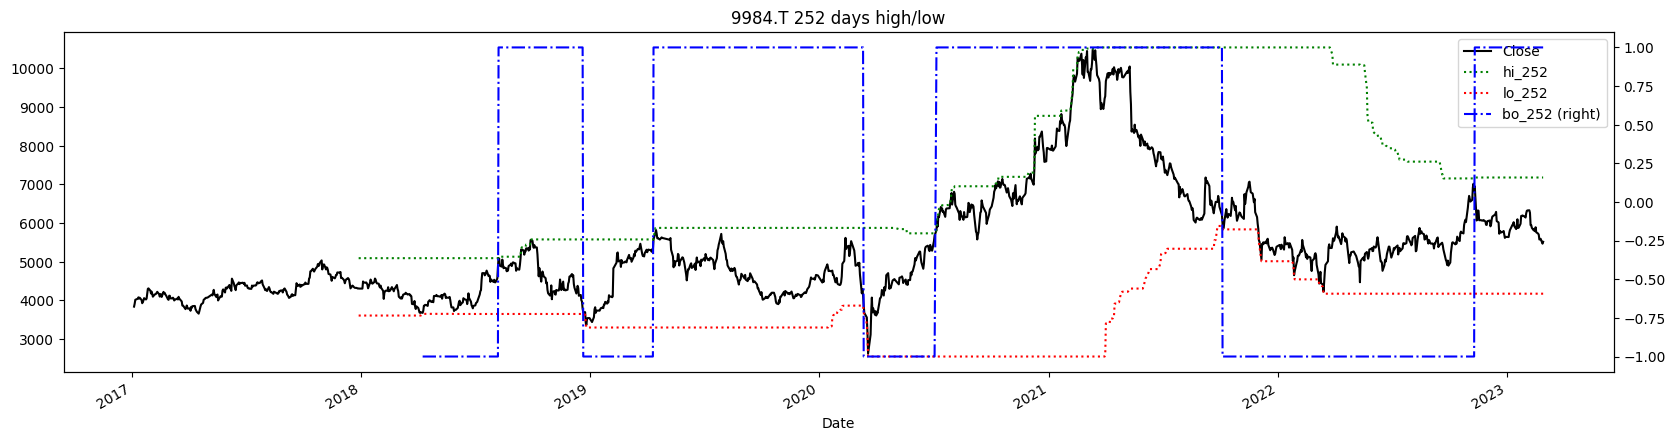

In [53]:
def regime_breakout(df, _h, _l, window):
    hl = np.where(df[_h] == df[_h].rolling(window).max(), 1,
                  np.where(df[_l] == df[_l].rolling(window).min(), -1, np.nan))
    roll_hl = pd.Series(index=df.index, data=hl).fillna(method='ffill')
    return roll_hl


ticker = '9984.T'  # Softbank
start = '2016-12-31'
end = None
df = yf.download(tickers=ticker, start=start, end=end, interval="1d",
                 group_by='column', auto_adjust=True, prepost=True,
                 threads=True, proxy=None)

window = 252
df['hi_' + str(window)] = df['High'].rolling(window).max()
df['lo_' + str(window)] = df['Low'].rolling(window).min()
df['bo_' + str(window)] = regime_breakout(df=df, _h='High', _l='Low', window=window)
df[['Close', 'hi_' + str(window), 'lo_' + str(window), 'bo_' + str(window)]].plot(secondary_y=['bo_' + str(window)],
                                                                                  figsize=(20, 5),
                                                                                  style=['k', 'g:', 'r:', 'b-.'],
                                                                                  title=str.upper(ticker) + ' ' + str(
                                                                                      window) + ' days high/low')

# Utilities Functions

In [54]:
def lower_upper_OHLC(df, relative=False):
    if relative == True:
        rel = 'r'
    else:
        rel = ''
    if 'Open' in df.columns:
        ohlc = [rel + 'Open', rel + 'High', rel + 'Low', rel + 'Close']
    elif 'open' in df.columns:
        ohlc = [rel + 'open', rel + 'high', rel + 'low', rel + 'close']

    try:
        _o, _h, _l, _c = [ohlc[h] for h in range(len(ohlc))]
    except:
        _o = _h = _l = _c = np.nan
    return _o, _h, _l, _c


def regime_args(df, lvl, relative=False):
    if ('Low' in df.columns) & (relative == False):
        reg_val = ['Lo1', 'Hi1', 'Lo' + str(lvl), 'Hi' + str(lvl), 'rg', 'clg', 'flr', 'rg_ch']
    elif ('low' in df.columns) & (relative == False):
        reg_val = ['lo1', 'hi1', 'lo' + str(lvl), 'hi' + str(lvl), 'rg', 'clg', 'flr', 'rg_ch']
    elif ('Low' in df.columns) & (relative == True):
        reg_val = ['rL1', 'rH1', 'rL' + str(lvl), 'rH' + str(lvl), 'rrg', 'rclg', 'rflr', 'rrg_ch']
    elif ('low' in df.columns) & (relative == True):
        reg_val = ['rl1', 'rh1', 'rl' + str(lvl), 'rh' + str(lvl), 'rrg', 'rclg', 'rflr', 'rrg_ch']

    try:
        rt_lo, rt_hi, slo, shi, rg, clg, flr, rg_ch = [reg_val[s] for s in range(len(reg_val))]
    except:
        rt_lo = rt_hi = slo = shi = rg = clg = flr = rg_ch = np.nan
    return rt_lo, rt_hi, slo, shi, rg, clg, flr, rg_ch

# Turtle Trading

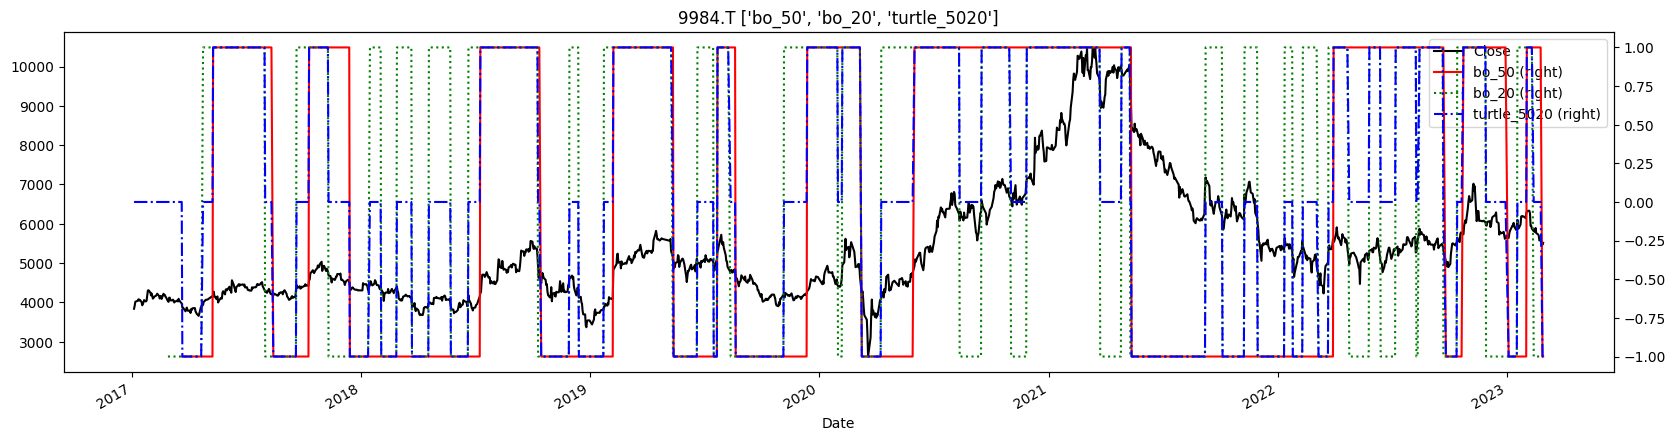

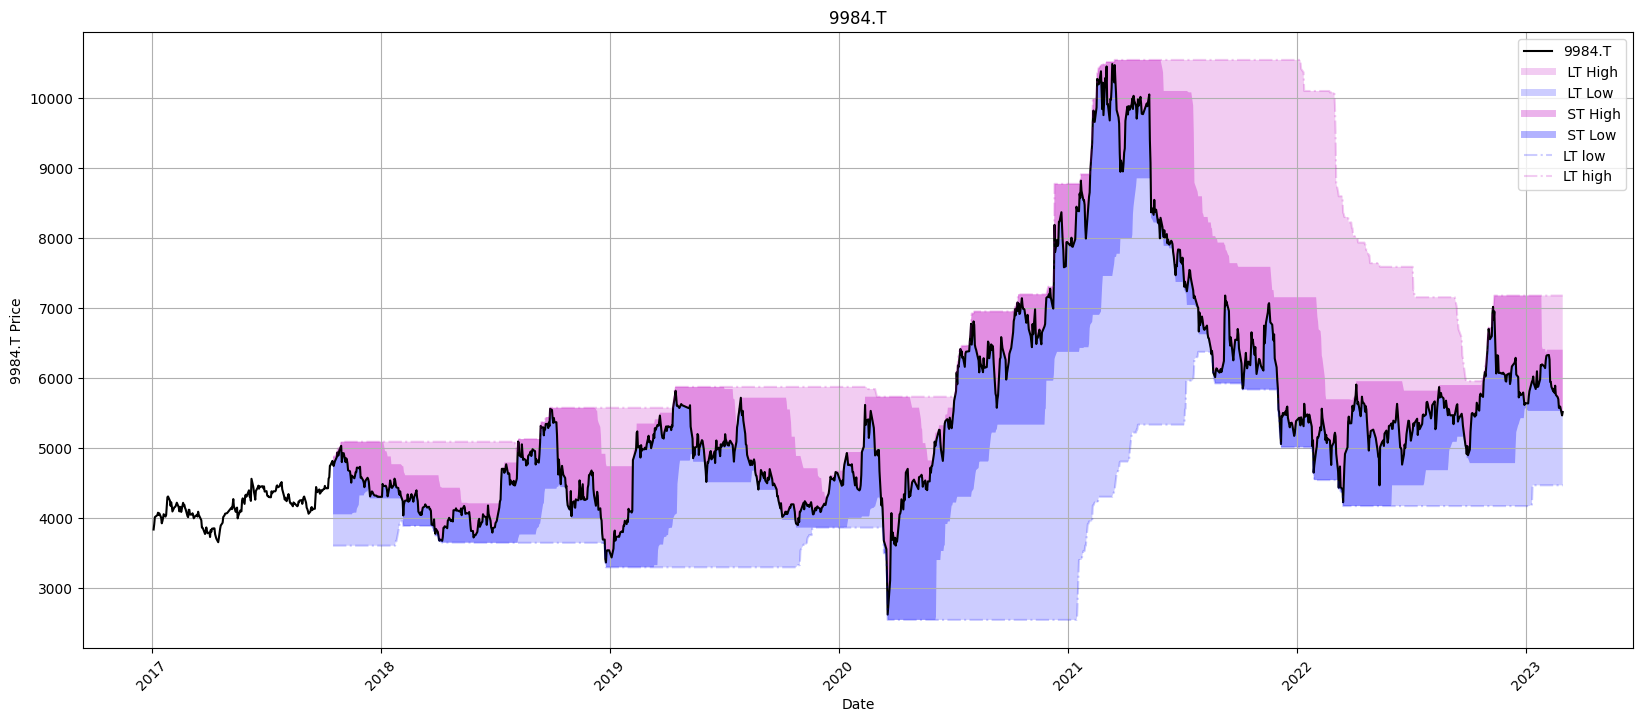

In [55]:
def turtle_trader(df, _h, _l, slow, fast):
    '''
    _slow: Long/Short direction
    _fast: trailing stop loss
    '''
    _slow = regime_breakout(df, _h, _l, window=slow)
    _fast = regime_breakout(df, _h, _l, window=fast)
    turtle = pd.Series(index=df.index,
                       data=np.where(_slow == 1, np.where(_fast == 1, 1, 0),
                                     np.where(_slow == -1, np.where(_fast == -1, -1, 0), 0)))
    return turtle


_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

fast = 20
slow = 50

df['bo_' + str(slow)] = regime_breakout(df, _h, _l, window=slow)
df['bo_' + str(fast)] = regime_breakout(df, _h, _l, window=fast)
df['turtle_' + str(slow) + str(fast)] = turtle_trader(df, _h, _l, slow, fast)
rg_cols = ['bo_' + str(slow), 'bo_' + str(fast), 'turtle_' + str(slow) + str(fast)]

df[['Close', 'bo_' + str(slow), 'bo_' + str(fast), 'turtle_' + str(slow) + str(fast)]].plot(
    secondary_y=rg_cols, figsize=(20, 5), style=['k', 'r', 'g:', 'b-.'],
    title=str.upper(ticker) + ' ' + str(rg_cols))

_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

ma_st = ma_mt = ma_lt = 0
rg = lo = hi = slo = shi = clg = flr = rg_ch = None

bo = [50, 200]
st_lo, lt_lo = [df[_l].rolling(window=bo[t]).min() for t in range(len(bo))]
st_hi, lt_hi = [df[_h].rolling(window=bo[t]).max() for t in range(len(bo))]

graph_regime_combo(ticker, df, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch, ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo,
                   st_hi)

# Moving Average Crossover

<Axes: title={'center': "9984.T ['sma_50200', 'ema_50200', 'turtle_5020']"}, xlabel='Date'>

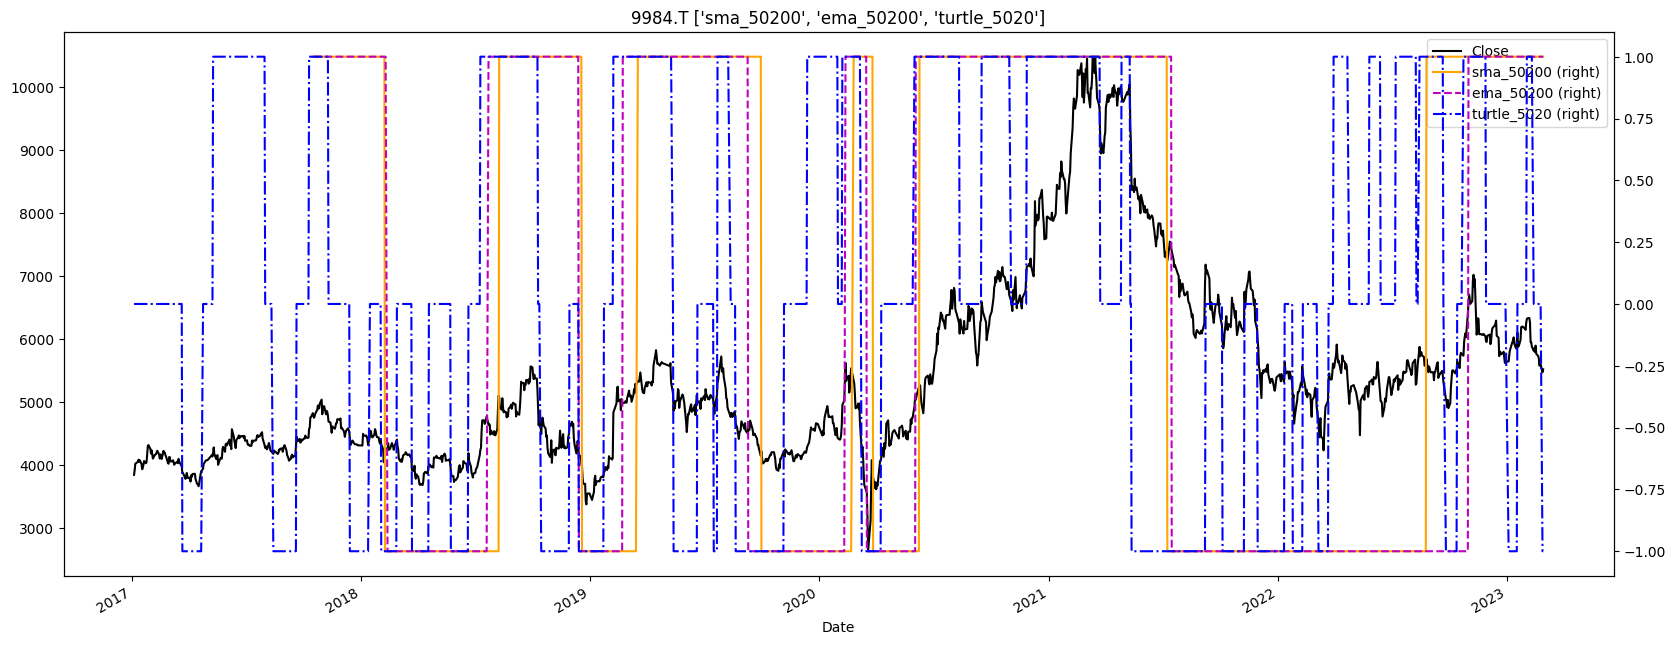

In [56]:
#### Regime SMA EMA ####
def regime_sma(df, _c, st, lt):
    '''
    bull +1: sma_st >= sma_lt , bear -1: sma_st <= sma_lt
    '''
    sma_lt = df[_c].rolling(lt).mean()
    sma_st = df[_c].rolling(st).mean()
    rg_sma = np.sign(sma_st - sma_lt)
    return rg_sma


def regime_ema(df, _c, st, lt):
    '''
    bull +1: ema_st >= ema_lt , bear -1: ema_st <= ema_lt
    '''
    ema_st = df[_c].ewm(span=st, min_periods=st).mean()
    ema_lt = df[_c].ewm(span=lt, min_periods=lt).mean()
    rg_ema = np.sign(ema_st - ema_lt)
    return rg_ema


st = 50
lt = 200
df['sma_' + str(st) + str(lt)] = regime_sma(df, _c='Close', st=st, lt=lt)
df['ema_' + str(st) + str(lt)] = regime_ema(df, _c='Close', st=st, lt=lt)

ohlc = ['Open', 'High', 'Low', 'Close']
_o, _h, _l, _c = [ohlc[h] for h in range(len(ohlc))]
rgme_cols = ['sma_' + str(st) + str(lt), 'ema_' + str(st) + str(lt), 'turtle_' + str(slow) + str(fast)]
df[['Close', 'sma_' + str(st) + str(lt), 'ema_' + str(st) + str(lt), 'turtle_' + str(slow) + str(fast)]].plot(
    secondary_y=rgme_cols, figsize=(20, 8), style=['k', 'orange', 'm--', 'b-.'],
    title=str.upper(ticker) + ' ' + str(rgme_cols))


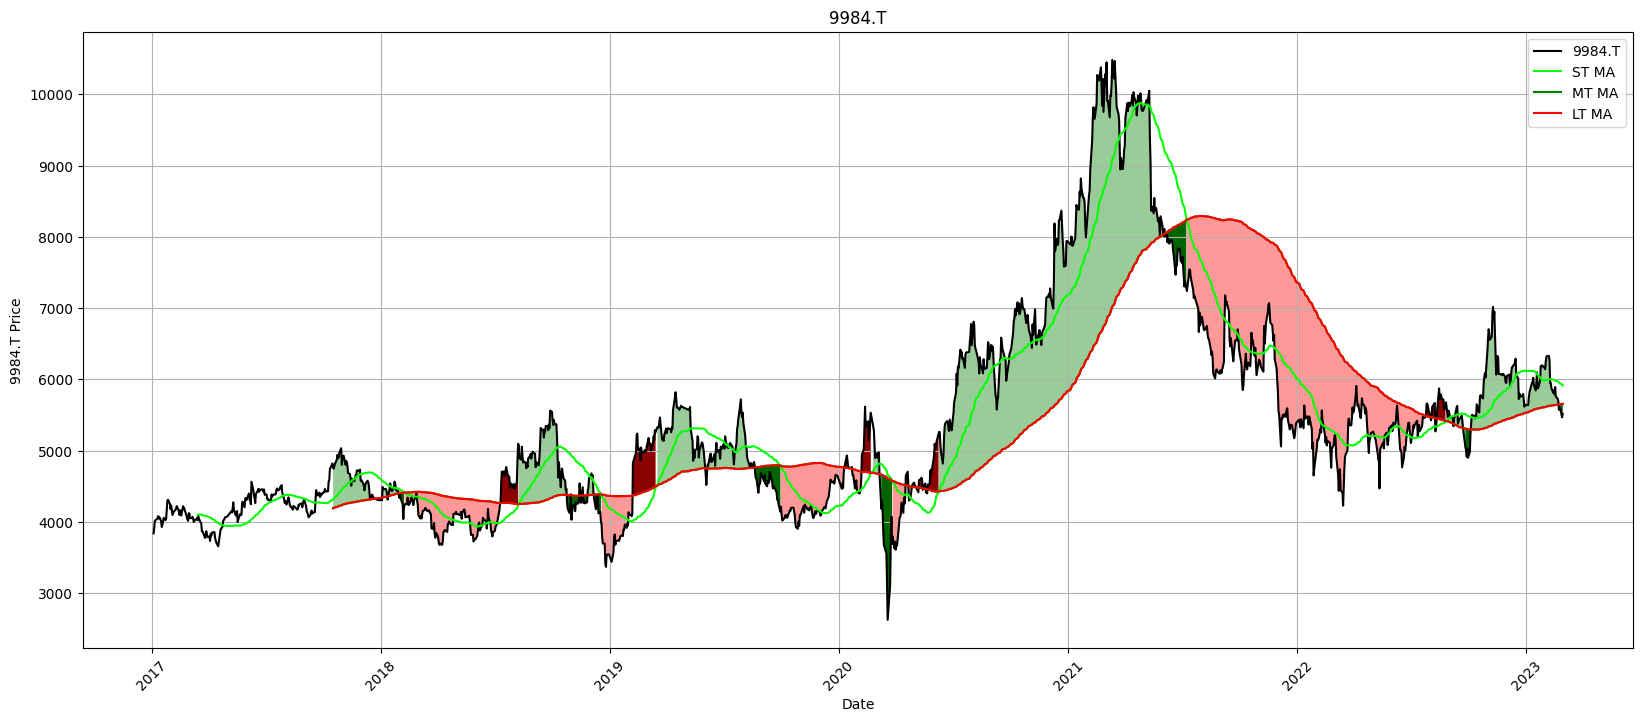

In [57]:
rg = lo = hi = slo = shi = clg = flr = rg_ch = None
lt_lo = lt_hi = st_lo = st_hi = 0

ma_st = df[_c].rolling(window=50).mean()
ma_mt = df[_c].rolling(window=200).mean()
ma_lt = df[_c].rolling(window=200).mean()
ohlc = ['Open', 'High', 'Low', 'Close']
_o, _h, _l, _c = [ohlc[h] for h in range(len(ohlc))]

graph_regime_combo(ticker, df, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch, ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo,
                   st_hi)


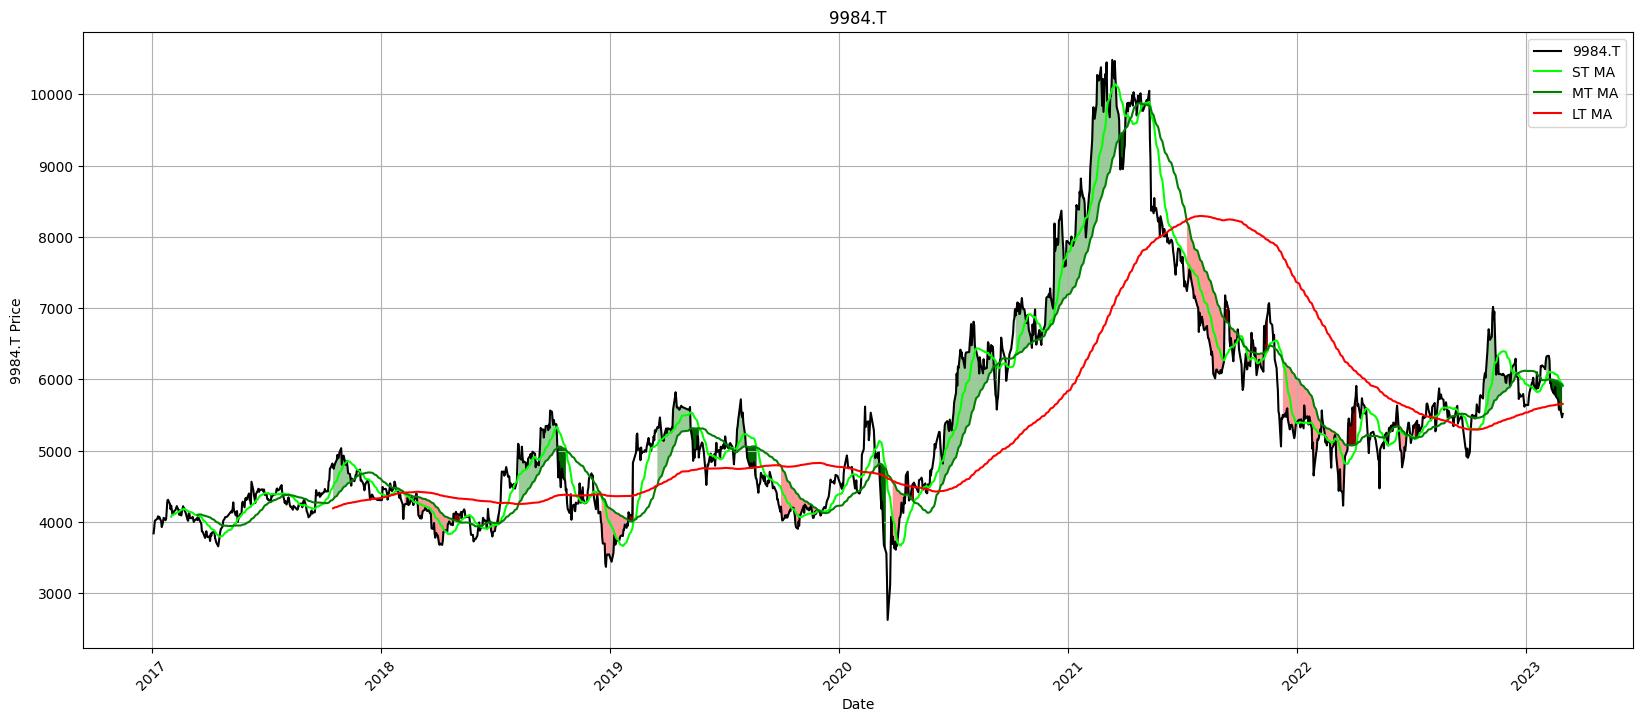

In [58]:
rg = lo = hi = slo = shi = clg = flr = rg_ch = None
lt_lo = lt_hi = st_lo = st_hi = 0

mav = [20, 50, 200]
ma_st, ma_mt, ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
ohlc = ['Open', 'High', 'Low', 'Close']
_o, _h, _l, _c = [ohlc[h] for h in range(len(ohlc))]

graph_regime_combo(ticker, df, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch, ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo,
                   st_hi)

In [59]:
ticker = 'SPY'

start = '2016-12-31'
end = None
raw_data = round(yf.download(tickers=ticker, start=start, end=end, interval="1d",
                             group_by='column', auto_adjust=True, prepost=True,
                             threads=True, proxy=None), 2)

_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

[*********************100%***********************]  1 of 1 completed


# Historical Swings

1. hilo_alternation: reduces a dataframe to a succession of highs & lows.
A. It eliminates same side consecutive highs and lows: highs are assigned a minus sign & lows a positive sign.
B. It keeps the lowest value marks the extreme point.
2. historical_swings: This is the fractal part of the algorithm where we look for the same pattern while zooming out. Creates multiple level columns of highs & lows. At the end of every iteration the hilo df is reduced using the dropna method.

<Axes: title={'center': 'SPY'}, xlabel='Date'>

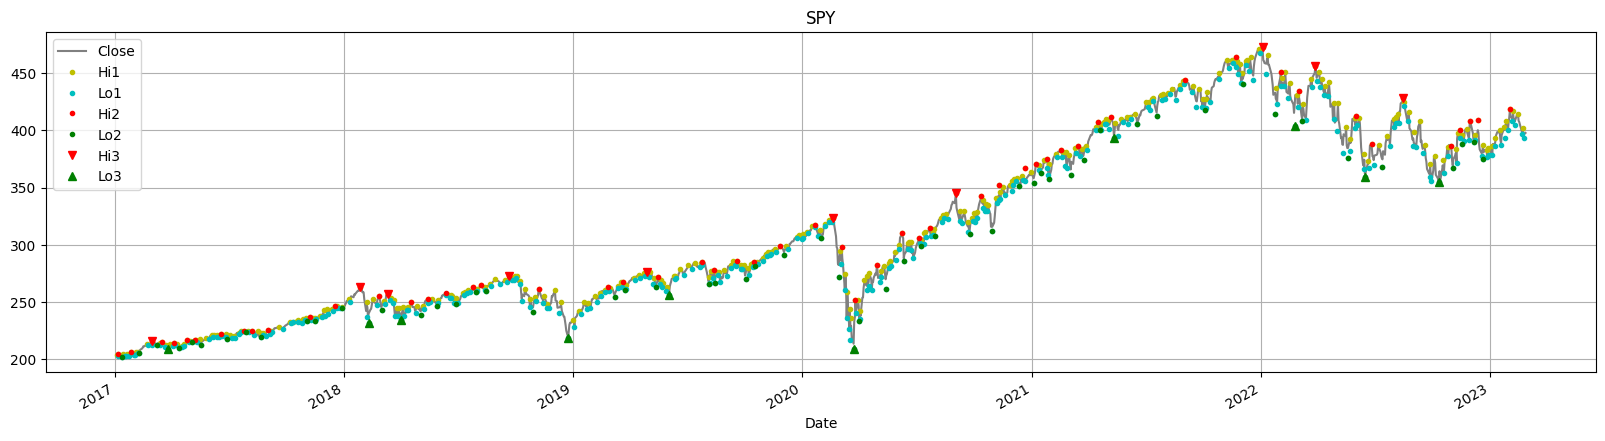

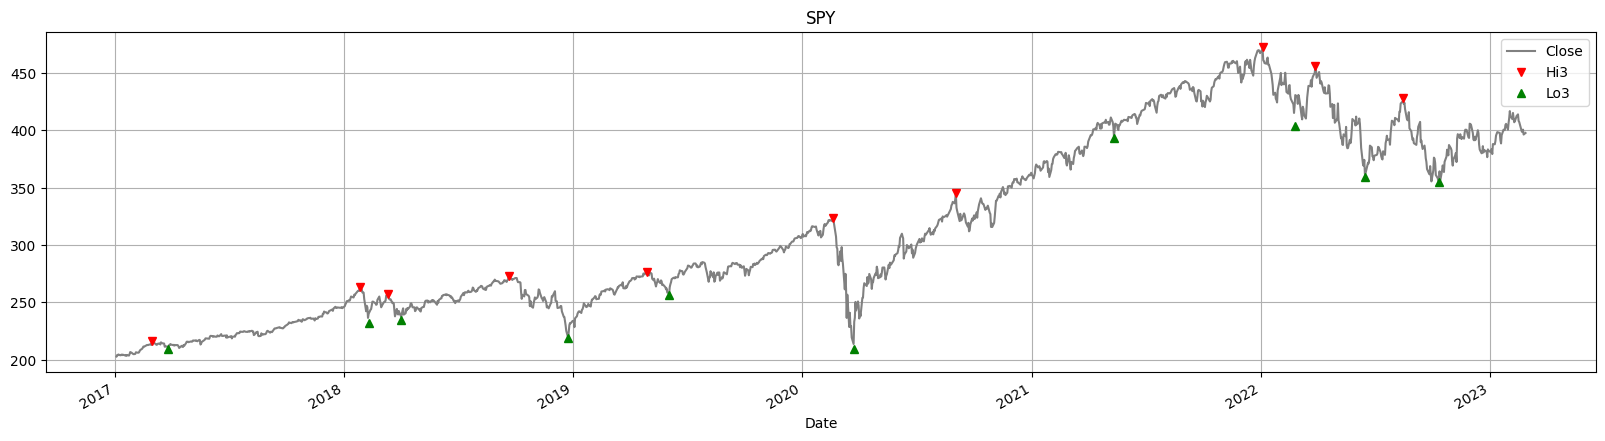

In [60]:
def hilo_alternation(hilo, dist=None, hurdle=None):
    i = 0
    while (np.sign(hilo.shift(1)) == np.sign(hilo)).any():  # runs until duplicates are eliminated

        # removes swing lows > swing highs
        hilo.loc[(np.sign(hilo.shift(1)) != np.sign(hilo)) &  # hilo alternation test
                 (hilo.shift(1) < 0) &  # previous datapoint:  high
                 (np.abs(hilo.shift(1)) < np.abs(hilo))] = np.nan  # high[-1] < low, eliminate low

        hilo.loc[(np.sign(hilo.shift(1)) != np.sign(hilo)) &  # hilo alternation
                 (hilo.shift(1) > 0) &  # previous swing: low
                 (np.abs(hilo) < hilo.shift(1))] = np.nan  # swing high < swing low[-1]

        # alternation test: removes duplicate swings & keep extremes
        hilo.loc[(np.sign(hilo.shift(1)) == np.sign(hilo)) &  # same sign
                 (hilo.shift(1) < hilo)] = np.nan  # keep lower one

        hilo.loc[(np.sign(hilo.shift(-1)) == np.sign(hilo)) &  # same sign, forward looking
                 (hilo.shift(-1) < hilo)] = np.nan  # keep forward one

        # removes noisy swings: distance test
        if pd.notnull(dist):
            hilo.loc[(np.sign(hilo.shift(1)) != np.sign(hilo)) & \
                     (np.abs(hilo + hilo.shift(1)).div(dist, fill_value=1) < hurdle)] = np.nan

        # reduce hilo after each pass
        hilo = hilo.dropna().copy()
        i += 1
        if i == 4:  # breaks infinite loop
            break
        return hilo


def historical_swings(df, _o, _h, _l, _c, dist=None, hurdle=None):
    reduction = df[[_o, _h, _l, _c]].copy()
    reduction['avg_px'] = round(reduction[[_h, _l, _c]].mean(axis=1), 2)
    highs = reduction['avg_px'].values
    lows = - reduction['avg_px'].values
    reduction_target = len(reduction) // 100

    n = 0
    while len(reduction) >= reduction_target:
        highs_list = find_peaks(highs, distance=1, width=0)
        lows_list = find_peaks(lows, distance=1, width=0)
        hilo = reduction.iloc[lows_list[0]][_l].sub(reduction.iloc[highs_list[0]][_h], fill_value=0)

        # Reduction dataframe and alternation loop
        hilo_alternation(hilo, dist=None, hurdle=None)
        reduction['hilo'] = hilo

        # Populate reduction df
        n += 1
        reduction[str(_h)[:2] + str(n)] = reduction.loc[reduction['hilo'] < 0, _h]
        reduction[str(_l)[:2] + str(n)] = reduction.loc[reduction['hilo'] > 0, _l]

        # Populate main dataframe
        df[str(_h)[:2] + str(n)] = reduction.loc[reduction['hilo'] < 0, _h]
        df[str(_l)[:2] + str(n)] = reduction.loc[reduction['hilo'] > 0, _l]

        # Reduce reduction
        reduction = reduction.dropna(subset=['hilo'])
        reduction.fillna(method='ffill', inplace=True)
        highs = reduction[str(_h)[:2] + str(n)].values
        lows = -reduction[str(_l)[:2] + str(n)].values

        if n >= 9:
            break

    return df


df = raw_data.copy()
_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)
rhs = ['Hi1', 'Lo1', 'Hi2', 'Lo2', 'Hi3', 'Lo3']
rt_hi, rt_lo, _hi, _lo, shi, slo = [rhs[h] for h in range(len(rhs))]

df = historical_swings(df, _o, _h, _l, _c, dist=None, hurdle=None)

df[[_c, rt_hi, rt_lo, _hi, _lo, shi, slo]].plot(
    style=['grey', 'y.', 'c.', 'r.', 'g.', 'rv', 'g^'],
    figsize=(20, 5), grid=True, title=str.upper(ticker))
df[[_c, shi, slo]].plot(style=['grey', 'rv', 'g^'],
                        figsize=(20, 5), grid=True, title=str.upper(ticker))

<Axes: title={'center': 'SPY post-adjustment'}, xlabel='Date'>

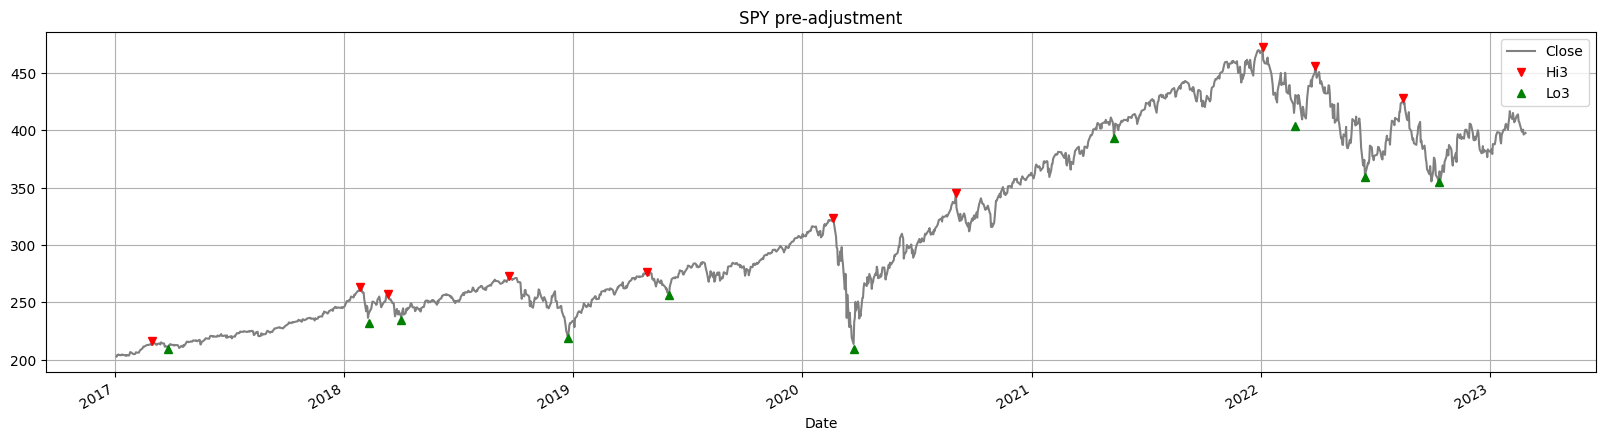

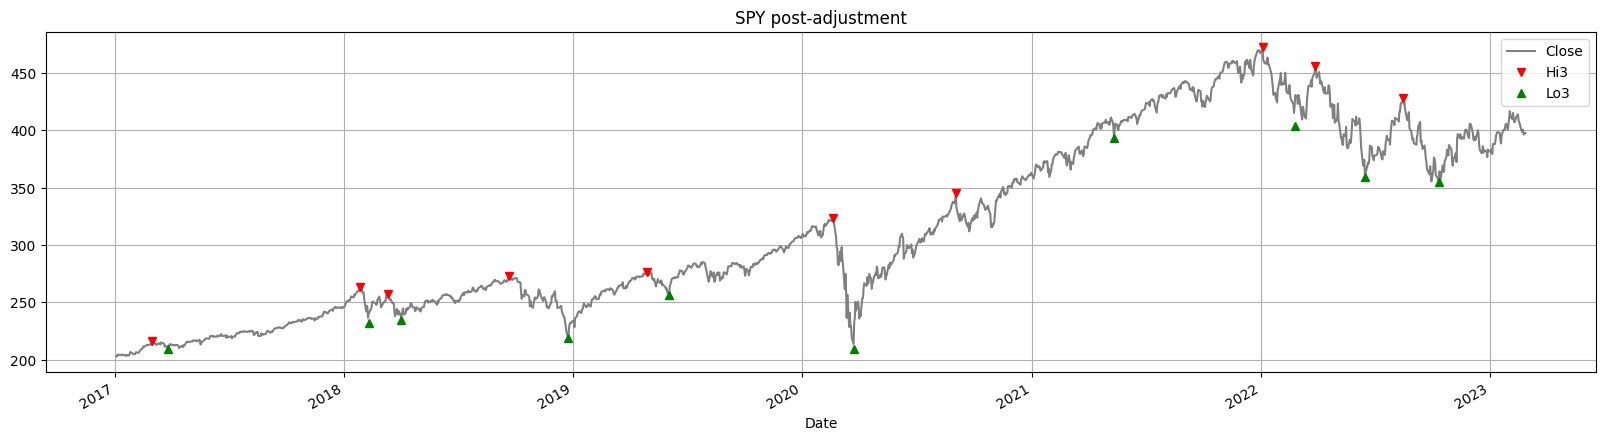

In [61]:
def cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo):
    '''
    removes false positives
    '''
    # latest swing
    shi_dt = df.loc[pd.notnull(df[shi]), shi].index[-1]
    s_hi = df.loc[pd.notnull(df[shi]), shi][-1]
    slo_dt = df.loc[pd.notnull(df[slo]), slo].index[-1]
    s_lo = df.loc[pd.notnull(df[slo]), slo][-1]
    len_shi_dt = len(df[:shi_dt])
    len_slo_dt = len(df[:slo_dt])

    # Reset false positives to np.nan
    for i in range(2):

        if (len_shi_dt > len_slo_dt) & ((df.loc[shi_dt:, rt_hi].max() > s_hi) | (s_hi < s_lo)):
            df.loc[shi_dt, shi] = np.nan
            len_shi_dt = 0
        elif (len_slo_dt > len_shi_dt) & ((df.loc[slo_dt:, rt_lo].min() < s_lo) | (s_hi < s_lo)):
            df.loc[slo_dt, slo] = np.nan
            len_slo_dt = 0
        else:
            pass

    return df


#### cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo) ####

df[[_c, shi, slo]].plot(style=['grey', 'rv', 'g^'],
                        figsize=(20, 5), grid=True, title=str.upper(ticker) + ' pre-adjustment')

df = cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo)

df[[_c, shi, slo]].plot(style=['grey', 'rv', 'g^'],
                        figsize=(20, 5), grid=True, title=str.upper(ticker) + ' post-adjustment')


In [62]:
#### latest_swings(df, shi, slo, rt_hi, rt_lo, _h, _l, _c, _vol) ####
def latest_swing_variables(df, shi, slo, rt_hi, rt_lo, _h, _l, _c):
    '''
    Latest swings dates & values
    '''
    shi_dt = df.loc[pd.notnull(df[shi]), shi].index[-1]
    slo_dt = df.loc[pd.notnull(df[slo]), slo].index[-1]
    s_hi = df.loc[pd.notnull(df[shi]), shi][-1]
    s_lo = df.loc[pd.notnull(df[slo]), slo][-1]

    if slo_dt > shi_dt:
        swg_var = [1, s_lo, slo_dt, rt_lo, shi, df.loc[slo_dt:, _h].max(), df.loc[slo_dt:, _h].idxmax()]
    elif shi_dt > slo_dt:
        swg_var = [-1, s_hi, shi_dt, rt_hi, slo, df.loc[shi_dt:, _l].min(), df.loc[shi_dt:, _l].idxmin()]
    else:
        ud = 0
    ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = [swg_var[h] for h in range(len(swg_var))]

    return ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt


#### latest_swings(df, shi, slo, rt_hi, rt_lo, _h, _l, _c, _vol) ####

ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = latest_swing_variables(df, shi, slo, rt_hi, rt_lo, _h, _l, _c)

ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt

(1,
 354.67,
 Timestamp('2022-10-12 00:00:00'),
 'Lo1',
 'Hi3',
 418.31,
 Timestamp('2023-02-02 00:00:00'))

In [63]:
#### test_distance(ud, bs, hh_ll, vlty, dist_vol, dist_pct) ####
def test_distance(ud, bs, hh_ll, dist_vol, dist_pct):
    # priority: 1. Vol 2. pct 3. dflt
    if (dist_vol > 0):
        distance_test = np.sign(abs(hh_ll - bs) - dist_vol)
    elif (dist_pct > 0):
        distance_test = np.sign(abs(hh_ll / bs - 1) - dist_pct)
    else:
        distance_test = np.sign(dist_pct)

    return int(max(distance_test, 0) * ud)


#### test_distance(ud, bs, hh_ll, vlty, dist_vol, dist_pct) ####
#### ATR ####
def average_true_range(df, _h, _l, _c, n):
    '''
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    '''
    atr = (df[_h].combine(df[_c].shift(), max) - df[_l].combine(df[_c].shift(), min)).rolling(window=n).mean()
    return atr


#### ATR ####

dist_vol = round(average_true_range(df, _h, _l, _c, n=63)[hh_ll_dt] * 2, 2)
dist_pct = 0.05
_sign = test_distance(ud, bs, hh_ll, dist_vol, dist_pct)
_sign

1

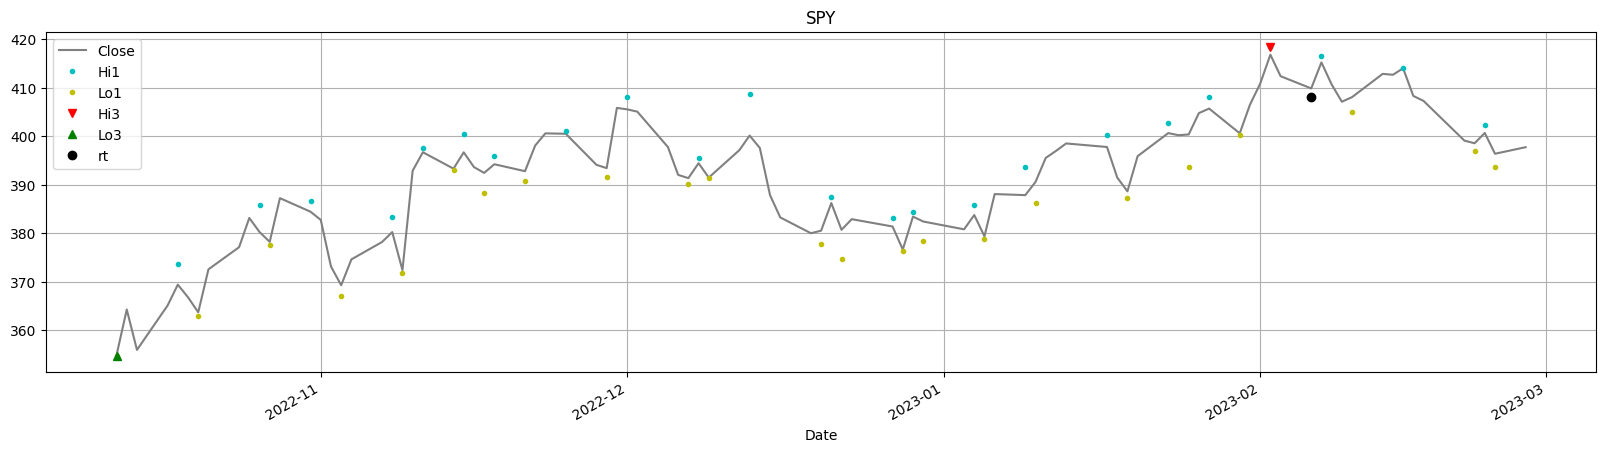

In [64]:
#### retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg) ####
def retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg):
    rt_sgmt = df.loc[hh_ll_dt:, _rt]

    if (rt_sgmt.count() > 0) & (_sign != 0):  # Retests exist and distance test met
        if _sign == 1:  #
            rt_list = [rt_sgmt.idxmax(), rt_sgmt.max(), df.loc[rt_sgmt.idxmax():, _c].cummin()]

        elif _sign == -1:
            rt_list = [rt_sgmt.idxmin(), rt_sgmt.min(), df.loc[rt_sgmt.idxmin():, _c].cummax()]
        rt_dt, rt_hurdle, rt_px = [rt_list[h] for h in range(len(rt_list))]

        if str(_c)[0] == 'r':
            df.loc[rt_dt, 'rrt'] = rt_hurdle
        elif str(_c)[0] != 'r':
            df.loc[rt_dt, 'rt'] = rt_hurdle

        if (np.sign(rt_px - rt_hurdle) == - np.sign(_sign)).any():
            df.at[hh_ll_dt, _swg] = hh_ll
    return df


#### retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg) ####

df = retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg)
try:
    df['rt '] = df['rt'].fillna(method='ffill')
    df[bs_dt:][[_c, rt_hi, rt_lo,
                shi, slo, 'rt']].plot(style=['grey', 'c.', 'y.',
                                             'rv', 'g^', 'ko'], figsize=(20, 5), grid=True, title=str.upper(ticker))
except:
    df[bs_dt:][[_c, rt_hi, rt_lo,
                shi, slo]].plot(style=['grey', 'c.', 'y.',
                                       'rv', 'g^', 'ko'], figsize=(20, 5), grid=True, title=str.upper(ticker))

<Axes: title={'center': 'SPY'}, xlabel='Date'>

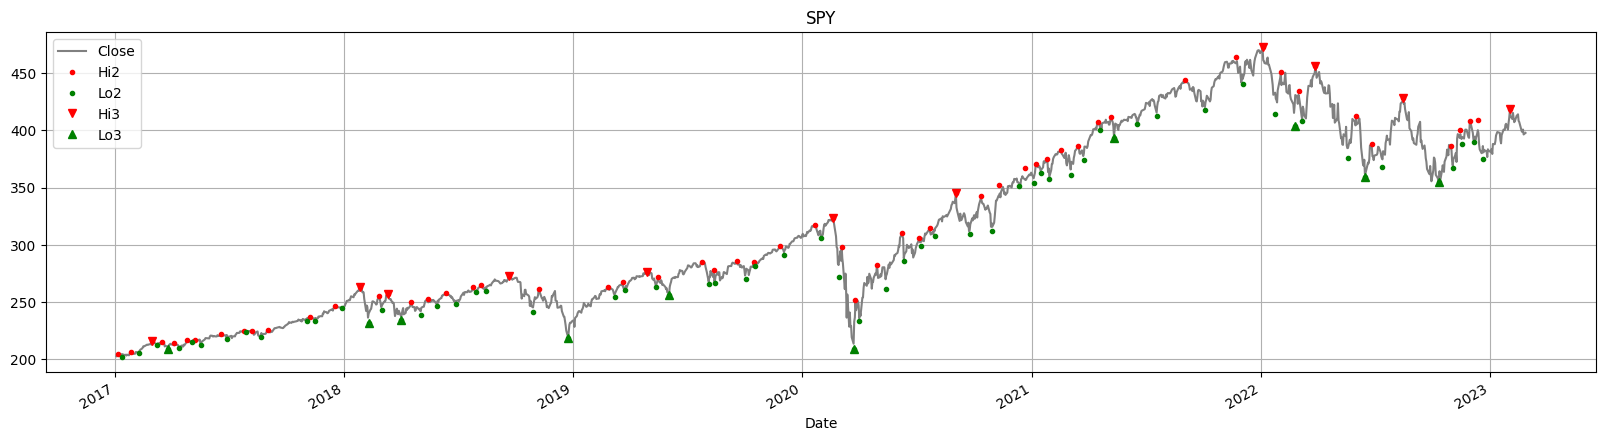

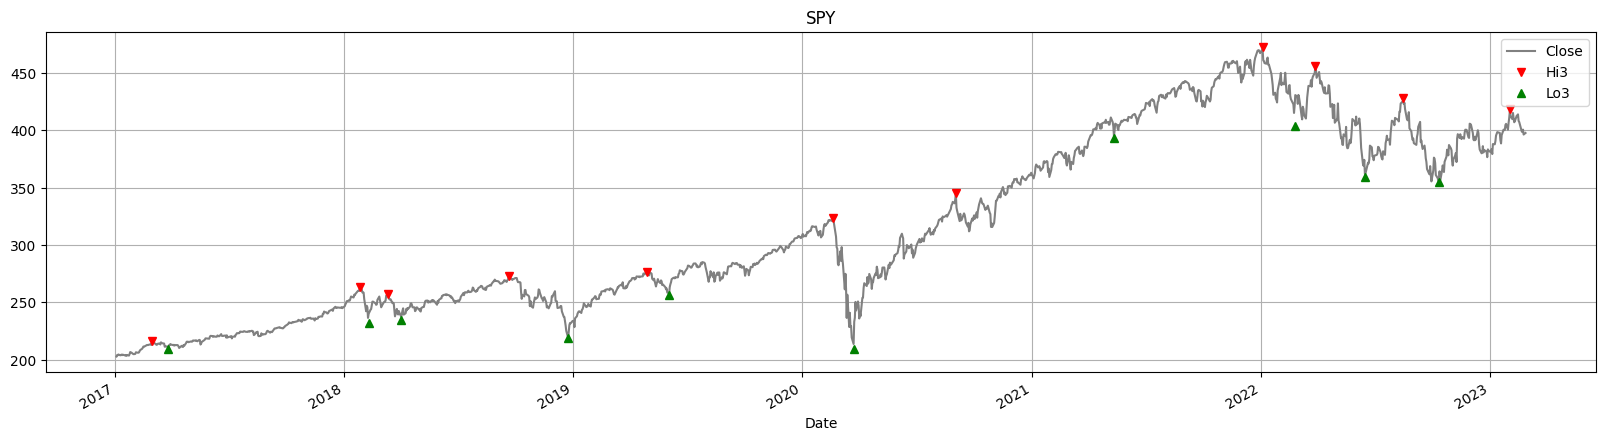

In [65]:
def retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct):
    if _sign == 1:
        retracement = df.loc[hh_ll_dt:, _c].min() - hh_ll

        if (vlty > 0) & (retrace_vol > 0) & ((abs(retracement / vlty) - retrace_vol) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll
        elif (retrace_pct > 0) & ((abs(retracement / hh_ll) - retrace_pct) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll

    elif _sign == -1:
        retracement = df.loc[hh_ll_dt:, _c].max() - hh_ll
        if (vlty > 0) & (retrace_vol > 0) & ((round(retracement / vlty, 1) - retrace_vol) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll
        elif (retrace_pct > 0) & ((round(retracement / hh_ll, 4) - retrace_pct) > 0):
            df.at[hh_ll_dt, _swg] = hh_ll
    else:
        retracement = 0
    return df


_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

vlty = round(average_true_range(df=df, _h=_h, _l=_l, _c=_c, n=63)[hh_ll_dt], 2)
dist_vol = 5 * vlty
dist_pct = 0.05
_sign = test_distance(ud, bs, hh_ll, dist_vol, dist_pct)
df = retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg)
retrace_vol = 2.5 * vlty
retrace_pct = 0.05
df = retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct)

df[[_c, _hi, _lo, shi, slo]].plot(
    style=['grey', 'r.', 'g.', 'rv', 'g^'],
    figsize=(20, 5), grid=True, title=str.upper(ticker))

df[[_c, shi, slo]].plot(style=['grey', 'rv', 'g^'],
                        figsize=(20, 5), grid=True, title=str.upper(ticker))

In [68]:
### RELATIVE
def relative(df, _o, _h, _l, _c, bm_df, bm_col, ccy_df, ccy_col, dgt, start, end, rebase=True):
    '''
    df: df
    bm_df, bm_col: df benchmark dataframe & column name
    ccy_df,ccy_col: currency dataframe & column name
    dgt: rounding decimal
    start/end: string or offset
    rebase: boolean rebase to beginning or continuous series
    '''
    # Slice df dataframe from start to end period: either offset or datetime
    df = df[start:end]

    # inner join of benchmark & currency: only common values are preserved
    df = df.join(bm_df[[bm_col]], how='inner')
    df = df.join(ccy_df[[ccy_col]], how='inner')

    # rename benchmark name as bm and currency as ccy
    df.rename(columns={bm_col: 'bm', ccy_col: 'ccy'}, inplace=True)

    # Adjustment factor: calculate the scalar product of benchmark and currency
    df['bmfx'] = round(df['bm'].mul(df['ccy']), dgt).fillna(method='ffill')
    if rebase == True:
        df['bmfx'] = df['bmfx'].div(df['bmfx'][0])

    # Divide absolute price by fxcy adjustment factor and rebase to first value
    df['r' + str(_o)] = round(df[_o].div(df['bmfx']), dgt)
    df['r' + str(_h)] = round(df[_h].div(df['bmfx']), dgt)
    df['r' + str(_l)] = round(df[_l].div(df['bmfx']), dgt)
    df['r' + str(_c)] = round(df[_c].div(df['bmfx']), dgt)
    df = df.drop(['bm', 'ccy', 'bmfx'], axis=1)

    return (df)

### RELATIVE ###

In [70]:
bm_df = pd.DataFrame()
bm_col = 'ONEQ'
ccy_col = 'USD'
dgt = 3
bm_df[bm_col] = round(yf.download(tickers=bm_col, start=start, end=end, interval="1d",
                                  group_by='column', auto_adjust=True, prepost=True,
                                  threads=True, proxy=None)['Close'], 2)
bm_df[ccy_col] = 1

df = raw_data.copy()
# ohlc = ['Open','High','Low','Close']
# _o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)
rhs = ['Hi1', 'Lo1', 'Hi2', 'Lo2', 'Hi3', 'Lo3']
rt_hi, rt_lo, _hi, _lo, shi, slo = [rhs[h] for h in range(len(rhs))]
df = relative(df, _o, _h, _l, _c, bm_df, bm_col, ccy_df=bm_df,
              ccy_col=ccy_col, dgt=dgt, start=start, end=end, rebase=True)

for a in np.arange(0, 2):
    df = historical_swings(df, _o, _h, _l, _c, dist=None, hurdle=None)
    df = cleanup_latest_swing(df, shi, slo, rt_hi, rt_lo)
    ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = latest_swing_variables(df, shi, slo, rt_hi, rt_lo, _h, _l, _c)
    vlty = round(average_true_range(df=df, _h=_h, _l=_l, _c=_c, n=63)[hh_ll_dt], 2)
    dist_vol = 5 * vlty
    dist_pct = 0.05
    _sign = test_distance(ud, bs, hh_ll, dist_vol, dist_pct)
    df = retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg)
    retrace_vol = 2.5 * vlty
    retrace_pct = 0.05
    df = retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct)
    _o, _h, _l, _c = lower_upper_OHLC(df, relative=True)
    rrhs = ['rH1', 'rL1', 'rH2', 'rL2', 'rH3', 'rL3']
    rt_hi, rt_lo, _hi, _lo, shi, slo = [rrhs[h] for h in range(len(rrhs))]

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'SPY vs ONEQ'}, xlabel='Date'>

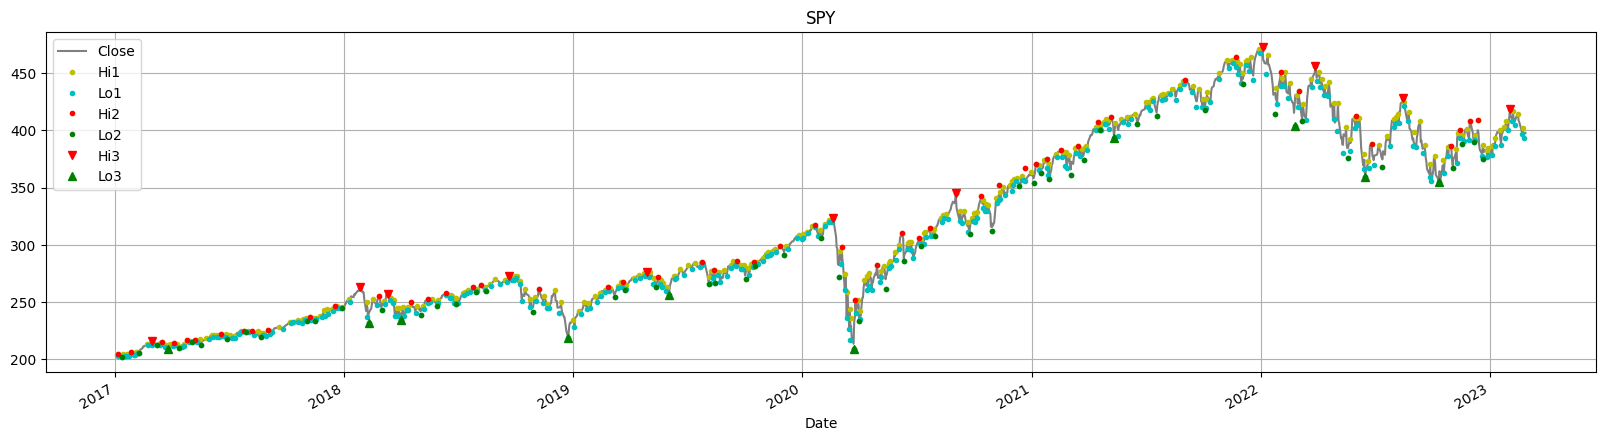

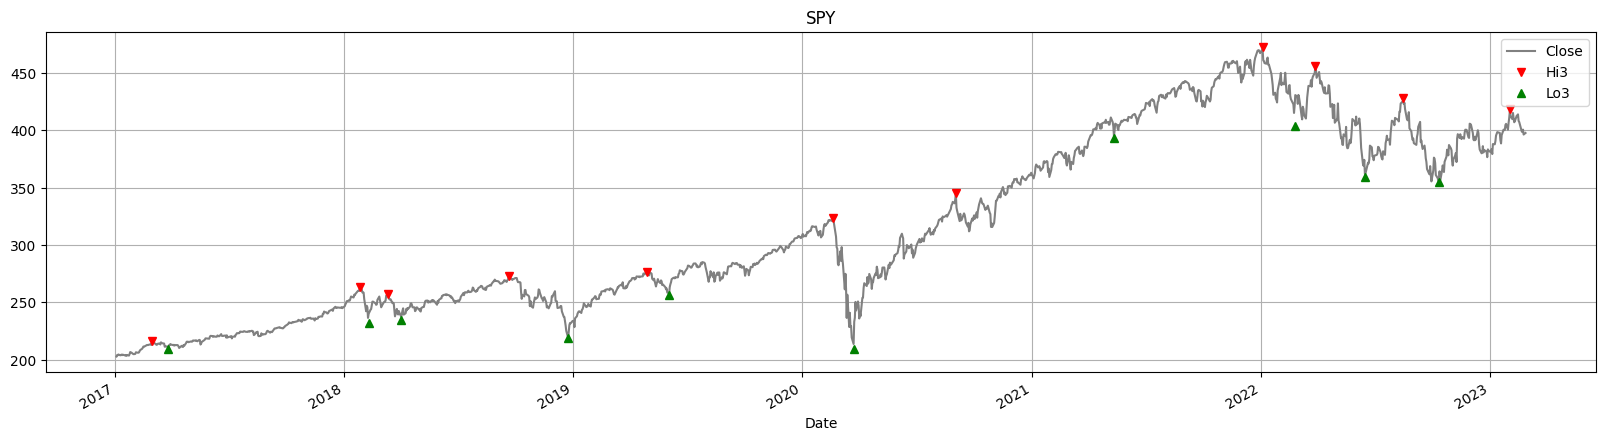

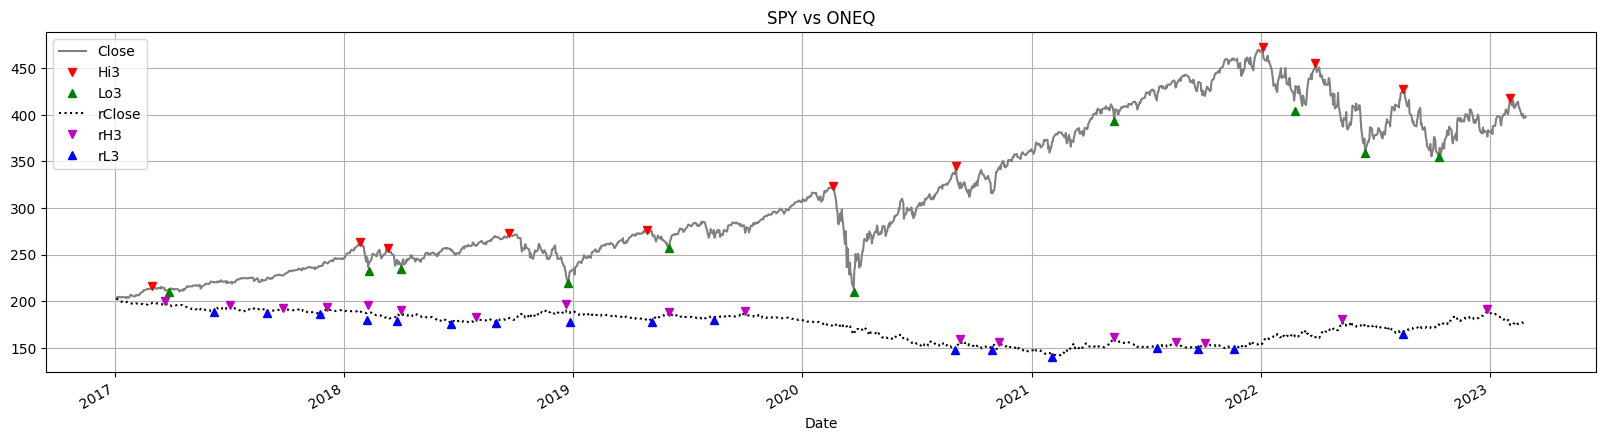

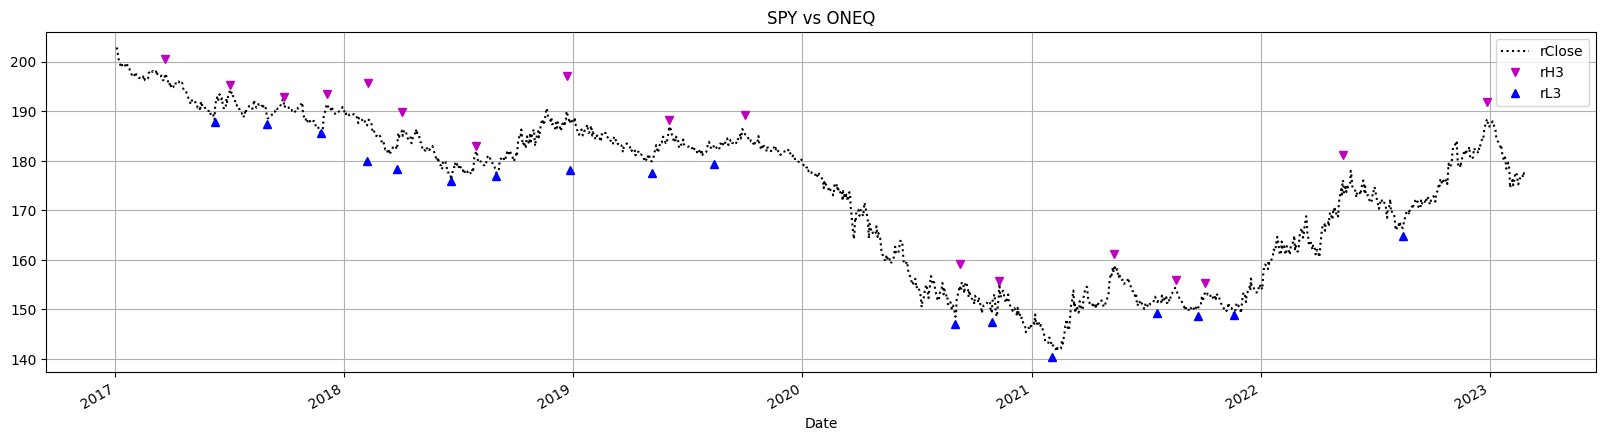

In [71]:
_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

df[['Close', 'Hi1', 'Lo1', 'Hi2', 'Lo2', 'Hi3', 'Lo3']].plot(style=['grey', 'y.', 'c.', 'r.', 'g.', 'rv', 'g^'],
                                                             figsize=(20, 5), grid=True, title=str.upper(ticker))

df[['Close', 'Hi3', 'Lo3']].plot(
    style=['grey', 'rv', 'g^'],
    figsize=(20, 5), grid=True, title=str.upper(ticker))

df[['Close', 'Hi3', 'Lo3', 'rClose', 'rH3', 'rL3']].plot(
    style=['grey', 'rv', 'g^', 'k:', 'mv', 'b^'],
    figsize=(20, 5), grid=True, title=str.upper(ticker) + ' vs ' + str.upper(bm_col))

df[['rClose', 'rH3', 'rL3']].plot(
    style=['k:', 'mv', 'b^'],
    figsize=(20, 5), grid=True, title=str.upper(ticker) + ' vs ' + str.upper(bm_col))

In [73]:
#### regime_floor_ceiling(df, hi,lo,cl, slo, shi,flr,clg,rg,rg_ch,stdev,threshold) ####
def regime_floor_ceiling(df, _h, _l, _c, slo, shi, flr, clg, rg, rg_ch, stdev, threshold):
    # Lists instantiation
    threshold_test, rg_ch_ix_list, rg_ch_list = [], [], []
    floor_ix_list, floor_list, ceiling_ix_list, ceiling_list = [], [], [], []

    ### Range initialisation to 1st swing
    floor_ix_list.append(df.index[0])
    ceiling_ix_list.append(df.index[0])

    ### Boolean variables
    ceiling_found = floor_found = breakdown = breakout = False

    ### Swings lists
    swing_highs = list(df[pd.notnull(df[shi])][shi])
    swing_highs_ix = list(df[pd.notnull(df[shi])].index)
    swing_lows = list(df[pd.notnull(df[slo])][slo])
    swing_lows_ix = list(df[pd.notnull(df[slo])].index)
    loop_size = np.maximum(len(swing_highs), len(swing_lows))

    ### Loop through swings
    for i in range(loop_size):

        ### asymetric swing list: default to last swing if shorter list
        try:
            s_lo_ix = swing_lows_ix[i]
            s_lo = swing_lows[i]
        except:
            s_lo_ix = swing_lows_ix[-1]
            s_lo = swing_lows[-1]

        try:
            s_hi_ix = swing_highs_ix[i]
            s_hi = swing_highs[i]
        except:
            s_hi_ix = swing_highs_ix[-1]
            s_hi = swing_highs[-1]

        swing_max_ix = np.maximum(s_lo_ix, s_hi_ix)  # latest swing index

        ### CLASSIC CEILING DISCOVERY
        if (ceiling_found == False):
            top = df[floor_ix_list[-1]: s_hi_ix][_h].max()
            ceiling_test = round((s_hi - top) / stdev[s_hi_ix], 1)

            ### Classic ceiling test
            if ceiling_test <= -threshold:
                ### Boolean flags reset
                ceiling_found = True
                floor_found = breakdown = breakout = False
                threshold_test.append(ceiling_test)

                ### Append lists
                ceiling_list.append(top)
                ceiling_ix_list.append(df[floor_ix_list[-1]: s_hi_ix][_h].idxmax())
                rg_ch_ix_list.append(s_hi_ix)
                rg_ch_list.append(s_hi)

                ### EXCEPTION HANDLING: price penetrates discovery swing
        ### 1. if ceiling found, calculate regime since rg_ch_ix using close.cummin
        elif (ceiling_found == True):
            close_high = df[rg_ch_ix_list[-1]: swing_max_ix][_c].cummax()
            df.loc[rg_ch_ix_list[-1]: swing_max_ix, rg] = np.sign(close_high - rg_ch_list[-1])

            ### 2. if price.cummax penetrates swing high: regime turns bullish, breakout
            if (df.loc[rg_ch_ix_list[-1]: swing_max_ix, rg] > 0).any():
                ### Boolean flags reset
                floor_found = ceiling_found = breakdown = False
                breakout = True

        ### 3. if breakout, test for bearish pullback from highest high since rg_ch_ix
        if (breakout == True):
            brkout_high_ix = df.loc[rg_ch_ix_list[-1]: swing_max_ix, _c].idxmax()
            brkout_low = df[brkout_high_ix: swing_max_ix][_c].cummin()
            df.loc[brkout_high_ix: swing_max_ix, rg] = np.sign(brkout_low - rg_ch_list[-1])

        ### CLASSIC FLOOR DISCOVERY
        if (floor_found == False):
            bottom = df[ceiling_ix_list[-1]: s_lo_ix][_l].min()
            floor_test = round((s_lo - bottom) / stdev[s_lo_ix], 1)

            ### Classic floor test
            if (floor_test >= threshold):
                ### Boolean flags reset
                floor_found = True
                ceiling_found = breakdown = breakout = False
                threshold_test.append(floor_test)

                ### Append lists
                floor_list.append(bottom)
                floor_ix_list.append(df[ceiling_ix_list[-1]: s_lo_ix][_l].idxmin())
                rg_ch_ix_list.append(s_lo_ix)
                rg_ch_list.append(s_lo)

        ### EXCEPTION HANDLING: price penetrates discovery swing
        ### 1. if floor found, calculate regime since rg_ch_ix using close.cummin
        elif (floor_found == True):
            close_low = df[rg_ch_ix_list[-1]: swing_max_ix][_c].cummin()
            df.loc[rg_ch_ix_list[-1]: swing_max_ix, rg] = np.sign(close_low - rg_ch_list[-1])

            ### 2. if price.cummin penetrates swing low: regime turns bearish, breakdown
            if (df.loc[rg_ch_ix_list[-1]: swing_max_ix, rg] < 0).any():
                floor_found = floor_found = breakout = False
                breakdown = True

                ### 3. if breakdown,test for bullish rebound from lowest low since rg_ch_ix
        if (breakdown == True):
            brkdwn_low_ix = df.loc[rg_ch_ix_list[-1]: swing_max_ix, _c].idxmin()  # lowest low
            breakdown_rebound = df[brkdwn_low_ix: swing_max_ix][_c].cummax()  # rebound
            df.loc[brkdwn_low_ix: swing_max_ix, rg] = np.sign(breakdown_rebound - rg_ch_list[-1])
    #             breakdown = False
    #             breakout = True

    ### POPULATE FLOOR,CEILING, RG CHANGE COLUMNS
    df.loc[floor_ix_list[1:], flr] = floor_list
    df.loc[ceiling_ix_list[1:], clg] = ceiling_list
    df.loc[rg_ch_ix_list, rg_ch] = rg_ch_list
    df[rg_ch] = df[rg_ch].fillna(method='ffill')

    ### regime from last swing
    df.loc[swing_max_ix:, rg] = np.where(ceiling_found,  # if ceiling found, highest high since rg_ch_ix
                                         np.sign(df[swing_max_ix:][_c].cummax() - rg_ch_list[-1]),
                                         np.where(floor_found,  # if floor found, lowest low since rg_ch_ix
                                                  np.sign(df[swing_max_ix:][_c].cummin() - rg_ch_list[-1]),
                                                  np.sign(df[swing_max_ix:][_c].rolling(5).mean() - rg_ch_list[-1])))
    df[rg] = df[rg].fillna(method='ffill')
    #     df[rg+'_no_fill'] = df[rg]
    return df

#### regime_floor_ceiling(df, hi,lo,cl, slo, shi,flr,clg,rg,rg_ch,stdev,threshold) ####

<Axes: title={'center': 'SPY'}, xlabel='Date'>

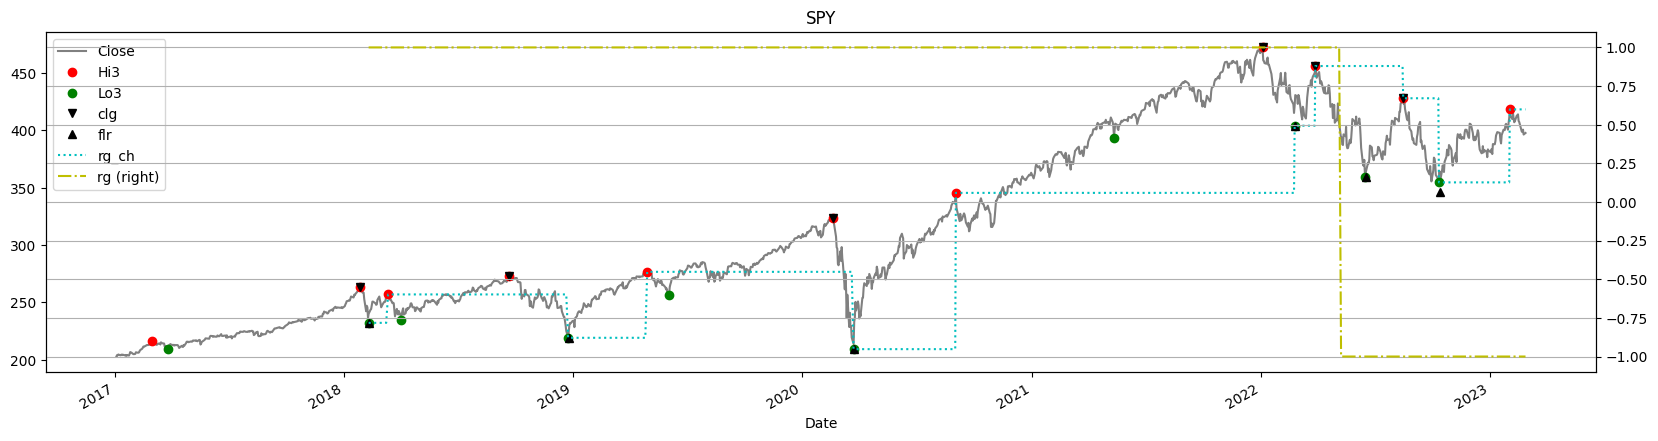

In [74]:
_o, _h, _l, _c = lower_upper_OHLC(df, relative=False)

stdev = df[_c].rolling(63).std(ddof=0)
rg_val = ['Hi3', 'Lo3', 'flr', 'clg', 'rg', 'rg_ch', 1.5]
slo, shi, flr, clg, rg, rg_ch, threshold = [rg_val[s] for s in range(len(rg_val))]
df = regime_floor_ceiling(df, _h, _l, _c, slo, shi, flr, clg, rg, rg_ch, stdev, threshold)

df[['Close', 'Hi3', 'Lo3', 'clg', 'flr', 'rg_ch', 'rg']].plot(style=['grey', 'ro', 'go', 'kv', 'k^', 'c:', 'y-.'],
                                                              secondary_y=['rg'], figsize=(20, 5), grid=True,
                                                              title=str.upper(ticker))

<Axes: title={'center': 'SPY'}, xlabel='Date'>

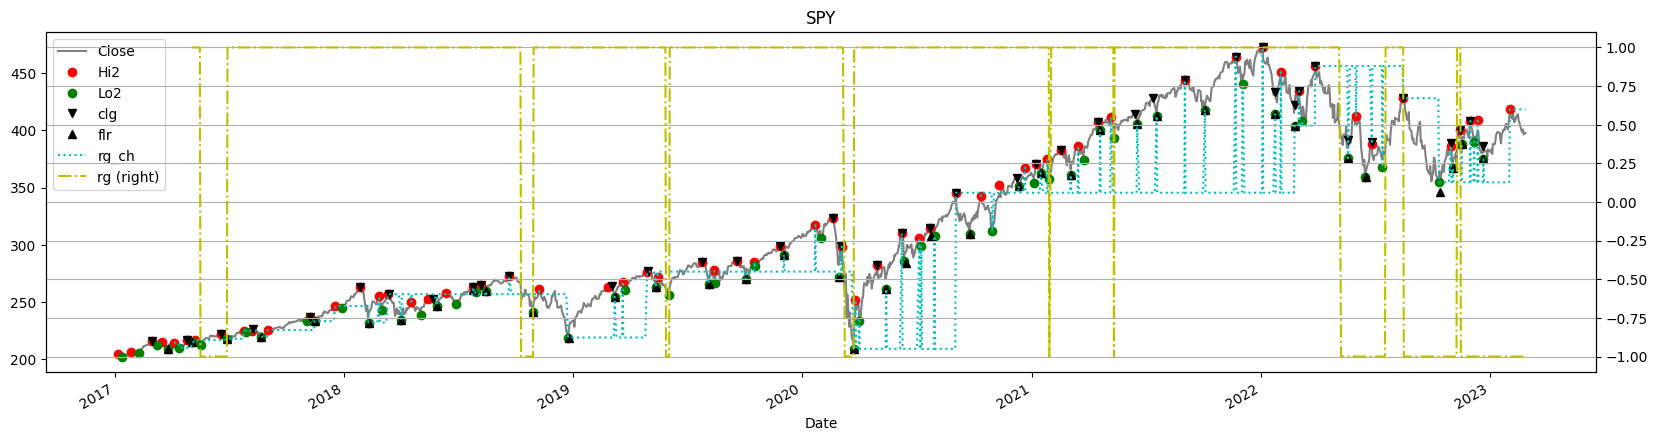

In [77]:
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

stdev = df[_c].rolling(63).std(ddof=0)
rg_val = ['Hi2','Lo2','flr','clg','rg','rg_ch',0.5]
slo, shi,flr,clg,rg,rg_ch,threshold = [rg_val[s] for s in range(len(rg_val))]
df = regime_floor_ceiling(df,_h,_l,_c,slo, shi,flr,clg,rg,rg_ch,stdev,threshold)

df[['Close','Hi2', 'Lo2','clg','flr','rg_ch','rg']].plot(
    style=['grey', 'ro', 'go', 'kv', 'k^','c:','y-.'],
    secondary_y= ['rg'],figsize=(20,5),grid=True, title = str.upper(ticker))

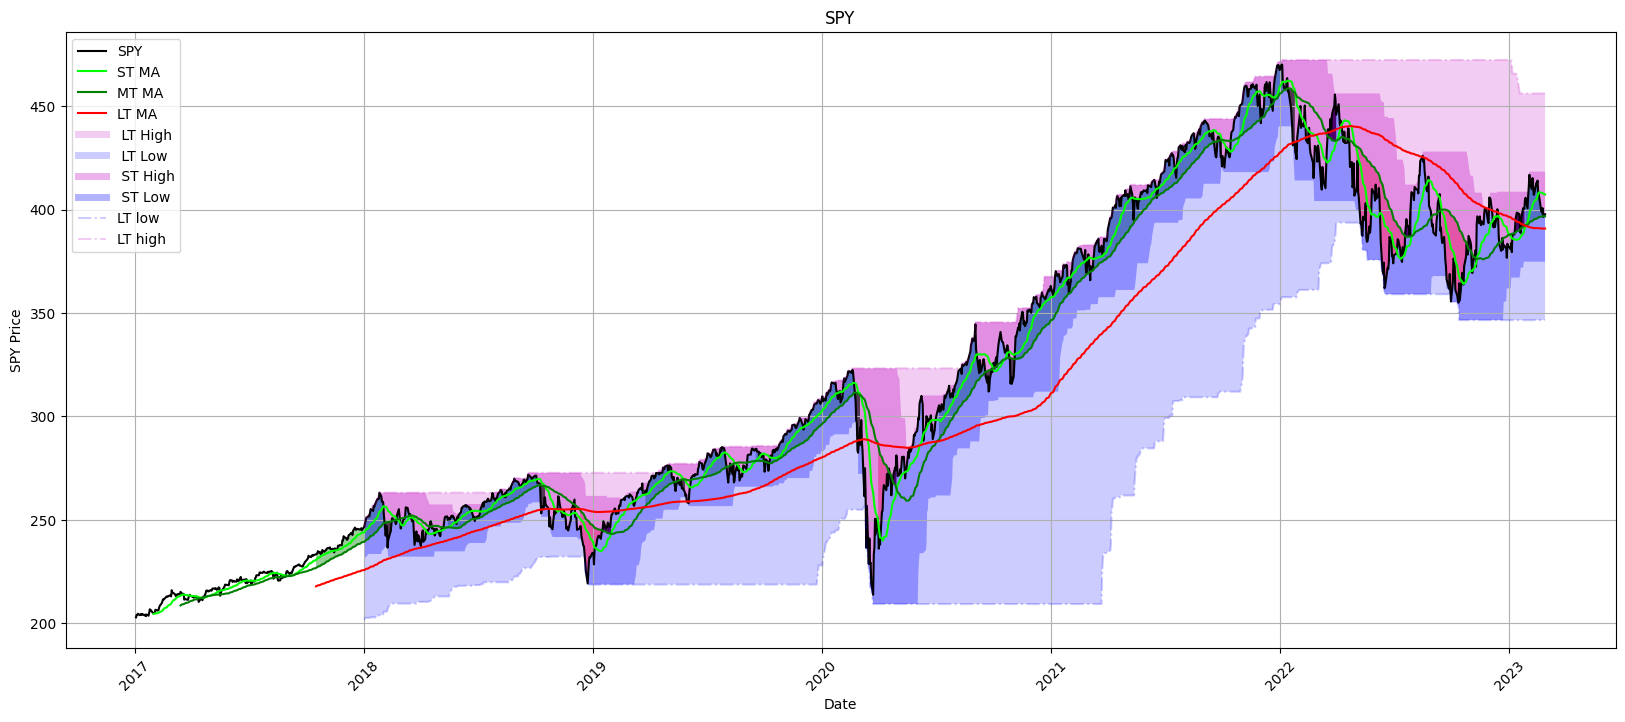

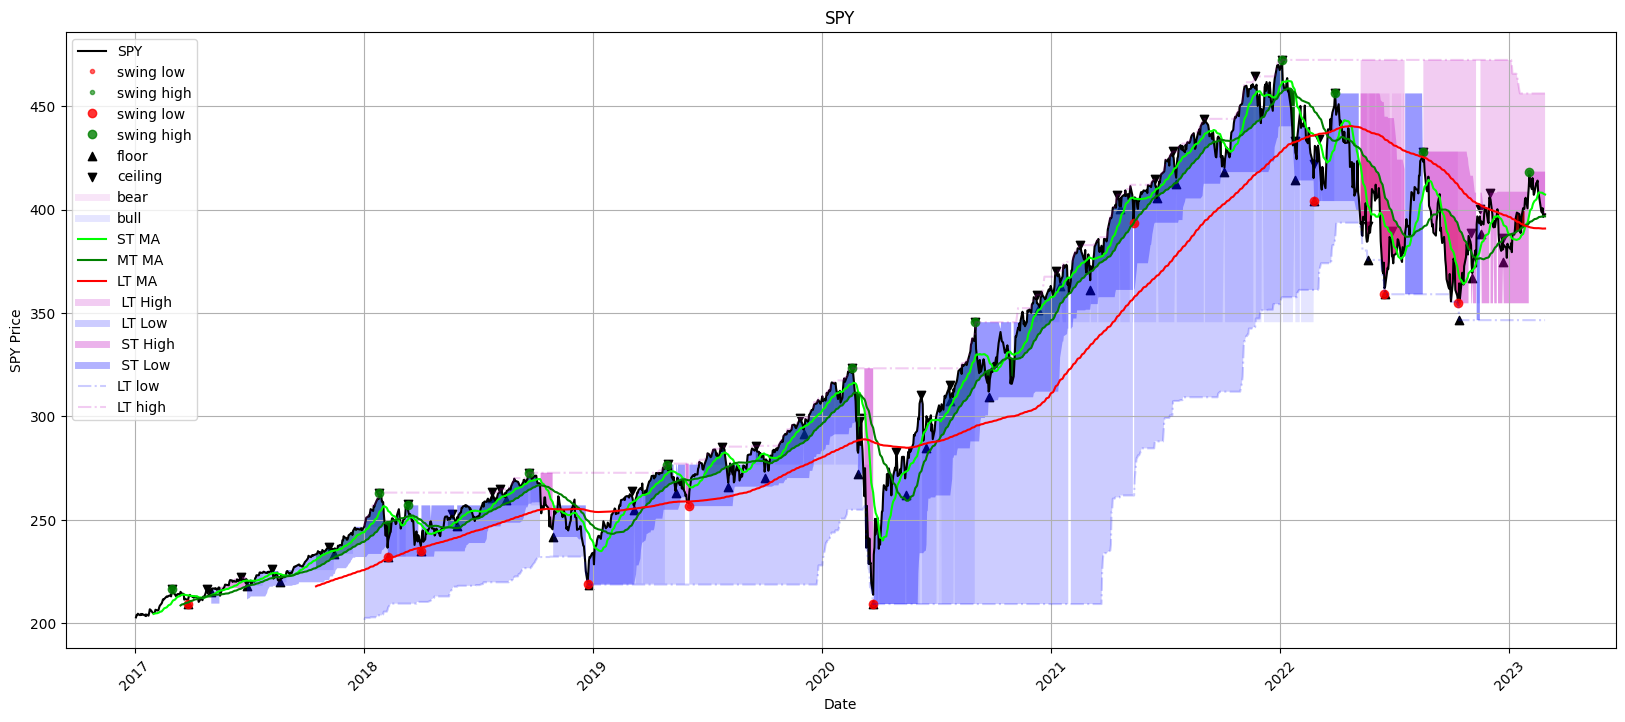

In [78]:
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

mav = [20, 50, 200]
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]

bo = [50, 252]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rg=lo=hi=slo=shi=clg=flr=rg_ch = None
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

rg_combo = ['Close','rg','Lo3','Hi3','Lo3','Hi3','clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]

graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'WFC Relative & Absolute'}, xlabel='Date'>

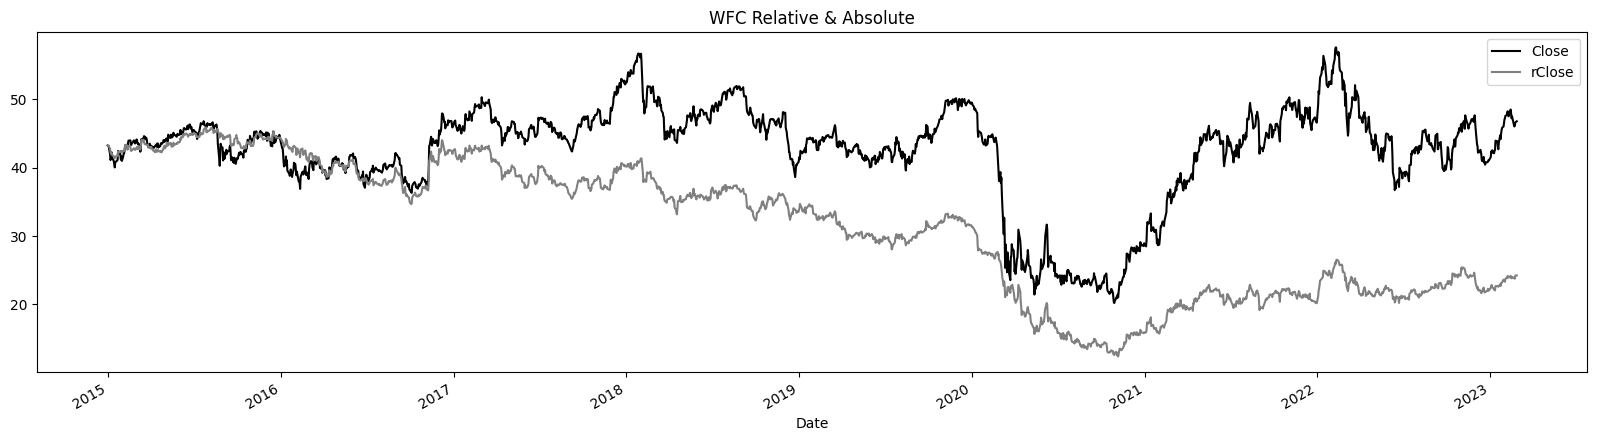

In [80]:
params = ['2014-12-31', None, 63, 0.05, 0.05, 1.5, 2]
start, end, vlty_n,dist_pct,retrace_pct,threshold,dgt= [params[h] for h in range(len(params))]

rel_var = ['^GSPC','SP500', 'USD']
bm_ticker, bm_col, ccy_col = [rel_var[h] for h in range(len(rel_var))]
bm_df = pd.DataFrame()
bm_df[bm_col] = round(yf.download(tickers= bm_ticker,start= start, end = end,interval = "1d",
                                  group_by = 'column',auto_adjust = True, prepost = True,
                                  threads = True, proxy = None)['Close'],dgt)
bm_df[ccy_col] = 1

ticker = 'WFC'
df = round(yf.download(tickers= ticker,start= start, end = end,interval = "1d",
                       group_by = 'column',auto_adjust = True, prepost = True,
                       threads = True, proxy = None),2)
# ohlc = ['Open','High','Low','Close']
# _o,_h,_l,_c = [ohlc[h] for h in range(len(ohlc))]
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)
df= relative(df=df,_o=_o,_h=_h,_l=_l,_c=_c, bm_df=bm_df, bm_col= bm_col, ccy_df=bm_df,
             ccy_col=ccy_col, dgt= dgt, start=start, end= end,rebase=True)

df[['Close','rClose']].plot(figsize=(20,5),style=['k','grey'],
                            title = str.upper(ticker)+ ' Relative & Absolute')

In [82]:
swing_val = ['rg','Lo1','Hi1','Lo3','Hi3','clg','flr','rg_ch']
rg,rt_lo,rt_hi,slo,shi,clg,flr,rg_ch = [swing_val[s] for s in range(len(swing_val))]

for a in np.arange(0,2):
    df = round(historical_swings(df,_o,_h,_l,_c, dist= None, hurdle= None),2)
    df = cleanup_latest_swing(df,shi,slo,rt_hi,rt_lo)
    ud, bs, bs_dt, _rt, _swg, hh_ll, hh_ll_dt = latest_swing_variables(df,
                                                                       shi,slo,rt_hi,rt_lo,_h,_l, _c)
    vlty = round(average_true_range(df,_h,_l,_c, n= vlty_n)[hh_ll_dt],2)
    dist_vol = 5 * vlty
    _sign = test_distance(ud,bs, hh_ll, dist_vol, dist_pct)
    df = retest_swing(df, _sign, _rt, hh_ll_dt, hh_ll, _c, _swg)
    retrace_vol = 2.5 * vlty
    df = retracement_swing(df, _sign, _swg, _c, hh_ll_dt, hh_ll, vlty, retrace_vol, retrace_pct)
    stdev = df[_c].rolling(vlty_n).std(ddof=0)
    df = regime_floor_ceiling(df,_h,_l,_c,slo, shi,flr,clg,rg,rg_ch,stdev,threshold)

    rohlc = ['rOpen','rHigh','rLow','rClose']
    _o,_h,_l,_c = [rohlc[h] for h in range(len(rohlc)) ]
    rswing_val = ['rrg','rL1','rH1','rL3','rH3','rclg','rflr','rrg_ch']
    rg,rt_lo,rt_hi,slo,shi,clg,flr,rg_ch = [rswing_val[s] for s in range(len(rswing_val))]


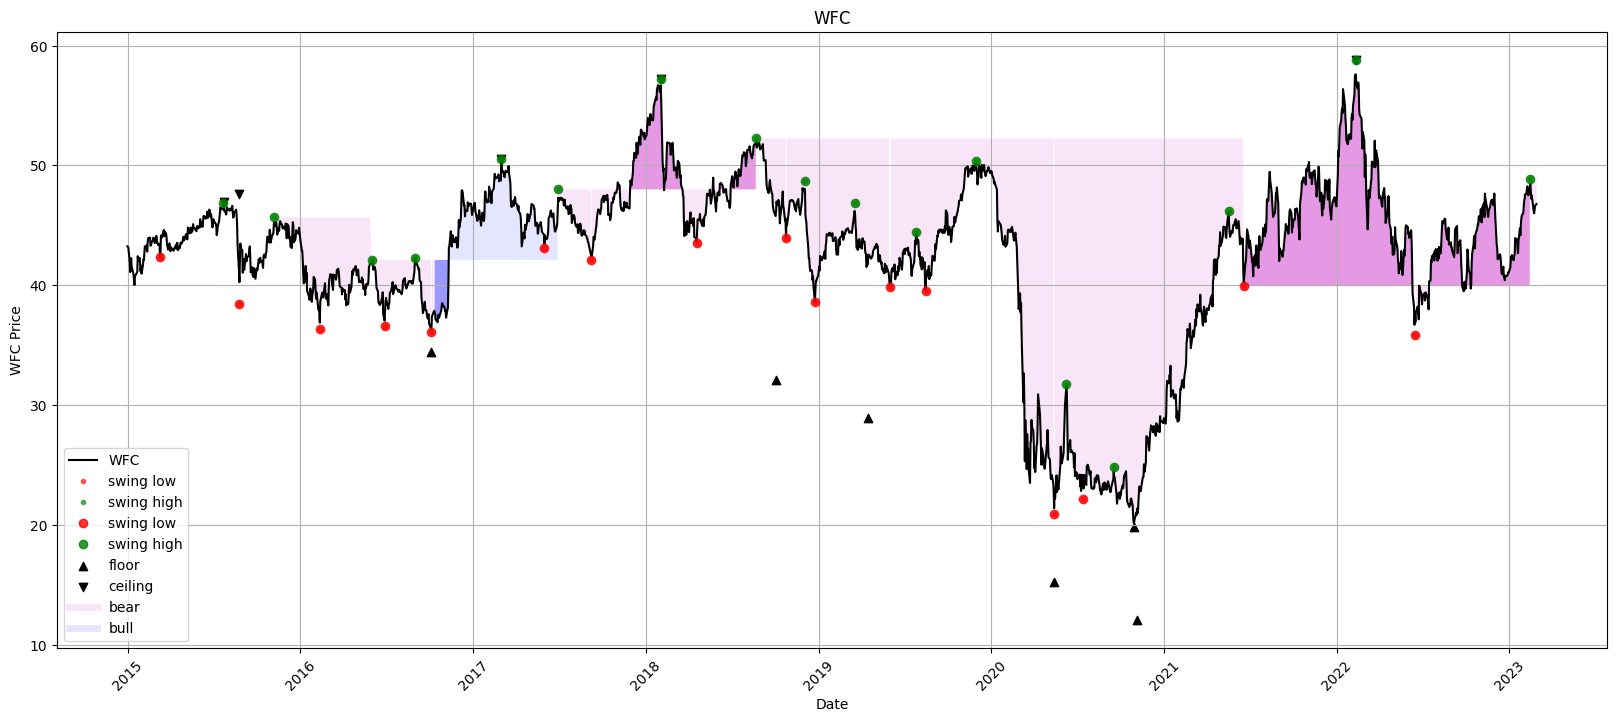

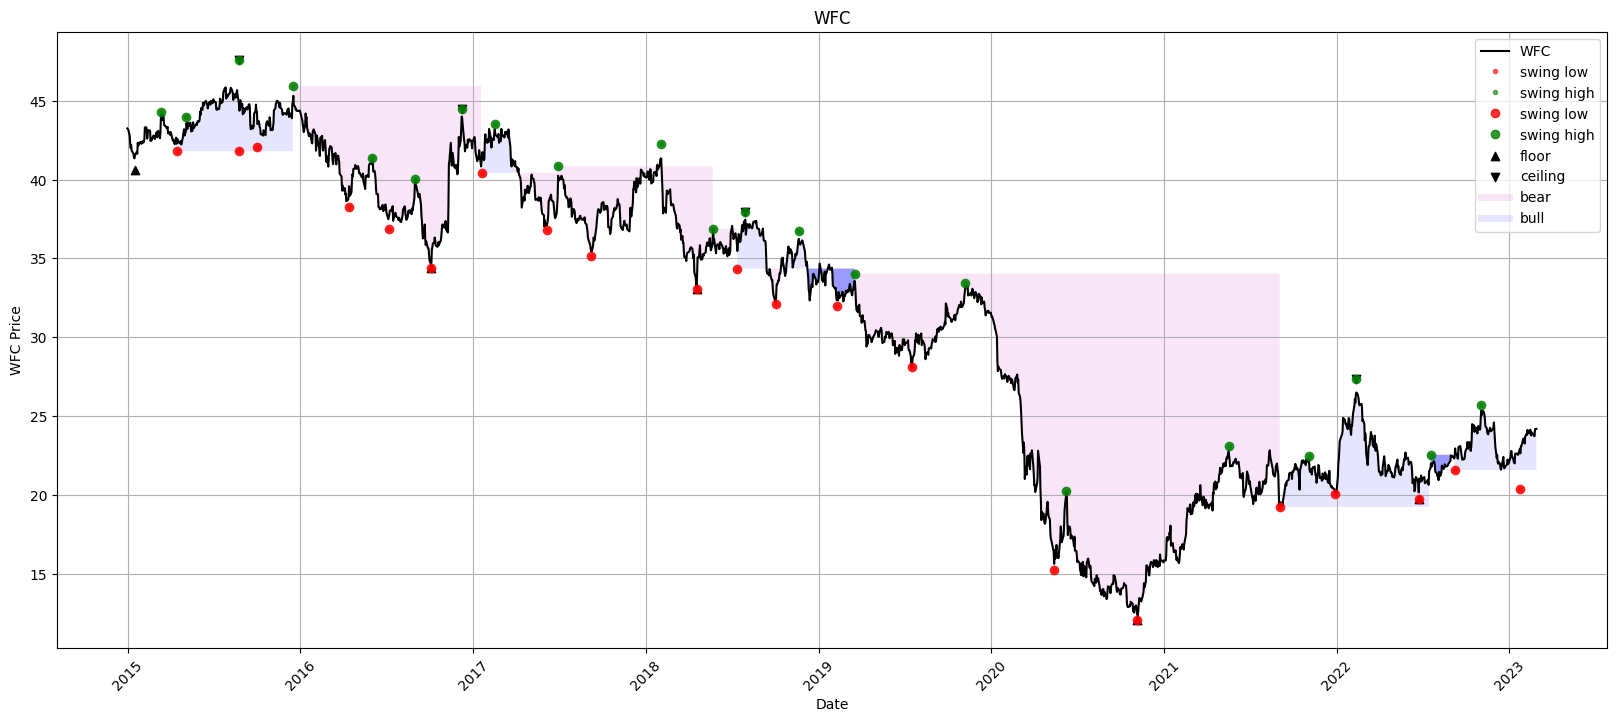

In [83]:
ma_st = ma_mt = ma_lt = lt_lo = lt_hi = st_lo = st_hi = 0

rg_combo = ['Close','rg','Lo3','Hi3','Lo3','Hi3','clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

rrg_combo = ['rClose','rrg','rL3','rH3','rL3','rH3','rclg','rflr','rrg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rrg_combo[r] for r in range(len(rrg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)
